## Introduction

The aims of this experiment is to use LSTM model to predict sentiment of Thai comment whether it is positive or negative comments. This notebook contain two experiments, without remove Thai stopwords and remove Thai stopword. This is because we want to see whether removing the stopwords would increase model prediction.

### Import libraries

In [582]:
from time import time
import pandas as pd
import numpy as np
from tensorflow import set_random_seed
import  matplotlib.pyplot as plt
import statistics
import random

import re

from pythainlp import word_tokenize, sent_tokenize, corpus
from pythainlp.tag import pos_tag, pos_tag_sents

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.wrappers.scikit_learn import KerasClassifier
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, Dropout, CuDNNLSTM, Bidirectional
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras.models import load_model
from keras.utils import to_categorical

import scikitplot as skplt
from sklearn.model_selection import train_test_split, ShuffleSplit
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import classification_report, confusion_matrix

from collections import Counter
from wordcloud import WordCloud

# for jupyter darktheme
import seaborn as sns
from jupyterthemes import jtplot
jtplot.style(theme='monokai', context='notebook', ticks=True, grid=False)

### Import data

In [445]:
# make dataframe to show max column width
pd.set_option('display.max_colwidth',-1)

In [446]:
df = pd.read_csv(r'./data/all_hosp.csv')
df = df.rename(columns = {'0':"comment_th", 
                          '1':"score",
                          '3':"hospital"})
df.drop(columns='2', inplace=True)

#### Visualize the scraped text

In [447]:
df.head()

,comment_th,score,hospital
0,ผมเคยไปทำเลสิกที่นี้ ดีมากครับตอนนี้ผ่ามาจะ2ปีแล้วยังไม่มีผลค้างเคียงอะไรและราคาก็ถูกดีด้วย ตอนผ่าอาจจะดูน่ากลัวไปซะหน่อย แต่พอถึงเวลาผ่าจริงๆแล้วไม่รู้สึกเจ็บเลยครับ เพราะมีการหยอดยาชาก่อนผ่า,4,rama
1,รักษามาหลายปีแล้วตั้งแต่อายุ14 ตอนนี้จะจบปริญญาตรีแล้ว ตั้งแต่นอนแอดมิดที่ รพ จนหายดีออกมาใช้ชีวิตได้เป็นปกติ โดยเฉพาะคลินิกพรีเมี่ยม ไม่ต้องรอนาน มีความสะดวกรวดเร็วทุกขั้นตอนตั้งแต่จ่ายเงินไปถึงจ่ายยา ค่ารักษาไม่ได้แพงเกินไปเมื่อเทียบเท่ากับเอกชนหลายๆที่ บริการดีมากๆ คุณหมอดูแลเอาใจใส่ดี อยากให้ทุกคนมารักษาที่นี่,5,rama
2,ที่ตึกพระเทพชั้น 2 สถานที่เครื่องมือดูทันสมัย \rแต่ที่ห้องวัดความดัน มีคนที่วัด(คิดว่าไม่ใช่พยาบาลเพราะใส่ชุดสีม่วง) ชอบดุคนที่มาวัด พูดเสียงแข็งใส่คนที่มาวัดความดัน ทั้งๆที่พยาบาลอีกคนที่ใส่ชุดพยาบาลพูดเพราะ อยากให้ปรับปรุง \r มาหาหมอที่แผนกศัลยกรรม อาจารย์หมอตรวตแล้วบอกต้องผ่าตัด บอกแค่ว่าต้องผ่าตัดถึงจะหายตอนนั้นช็อคเรื่องผ่าตัดอยู่เลยไม่ได้ถามอะไรเลย แล้วหมอกก็ไปเลยไม่ได้บอกว่าจริงๆเป็นอะไร ระยะไหน (ริดสีดวง) แล้วก็นัดวันผ่า พยาบาลที่นัดคิวก็ไม่สนเวลาเราทวนสิ่งที่บอกมาว่าถูกต้องไหม บอกแค่ว่าตามนั้นแหละ สรุปแล้วเหมือนจะดีแต่รอดูช่วงผ่าตัดก่อน,3,rama
3,"Its a public hospital so service is bad (nurses are completely unfriendly and doctors have god complex plus horrifying bed side manner) but they will keep you alive (nothing to do with quality of life) with decent drug collection. Young doctors are generally very friendly but they are busy all the time due to the amount of patients (like canned tuna) so don't expect them to spend too much time diagnosing you. You have to come early in the morning to ensure you're in queue and the wait 1-2 (bad days) hours behind schedule to get to see the doctor for < 15 min or less (all together door to door 8-9hrs). \r Additionally you can call all the 8 numbers on the websites from normal clinic to Premium and wait 15 minutes on each number just for them to hang up on you or divert you elsewhere then hang up on you.....\r Worst are the guys doing the schedule because they are very consistent in demonstrating the inability to manage schedules (or not) because you will ""always"" have to wait 1-2 hours ""after"" your appointment schedule to see the doctor but they also cant tell you that so you cant go anywhere and have to hang around the front door. \r In the better days you will get to sit inside the doctor's room to wait because the doctor is no where to be found and nobody will know when he/she will come back. If you ask the nurse they will give you the ""i dont know and I couldnt care less"" look and turn away in annoyance. \r But yes, they have great ability (the doctors definitely know what they are doing) to use ur tax fund to keep you alive, two stars for that!!\r Updated review for ER: The best ER u can probably find in Bangkok as they are 24hrs fully staffed with specialty doctors (not just general doctors like other hospitals during off business hours). They are jammed packed but they are fully equipped and by that I mean they have CT scanner in the ER room - this is not something we find everywhere. Doctors know what they are doing and fully equipped with the tools to keep u alive.\r Even better update:\r Just decided to go for full blown annual health check at Rama (Feb 2016) and here are the pros and cons:\r Cons:\rAs a foreigner who pays tax in Thailand ur sort of half screwed. They are not equipped to handle foreign language so if u cant google medical terms properly u might go home thinking everything is perfect when its not...A less life threatening case is that if u pay tax to Thailand ur entitled to Thai citizen price 30% less or so which is surprisingly logical BUT not without flaws...u have to bring the ""physical"" ""original"" tax receipt from revenue dept to show then which u DONT get if u file electronically....so....who does NOT file electronically? I dont know one....maybe my parents but they're 75....\r Pros:\rOmg its a very pleasant surprise that this clinic operates with the speed, manner, and professionalism that 

### Data Preprocess

In [448]:
# Transform the score only into positive (1) and negative (0)

def pos_neg(x):
    if x <= 3:
        x = 0
    else:
        x = 1
    return x

df.score = df.score.apply(pos_neg)

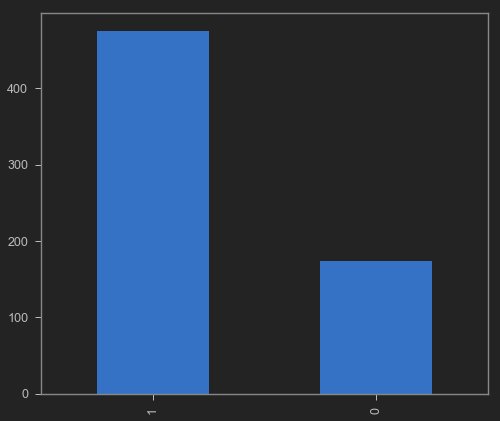

In [449]:
df.score.value_counts().plot(kind='bar')

In [450]:
df.head(2)

,comment_th,score,hospital
0,ผมเคยไปทำเลสิกที่นี้ ดีมากครับตอนนี้ผ่ามาจะ2ปีแล้วยังไม่มีผลค้างเคียงอะไรและราคาก็ถูกดีด้วย ตอนผ่าอาจจะดูน่ากลัวไปซะหน่อย แต่พอถึงเวลาผ่าจริงๆแล้วไม่รู้สึกเจ็บเลยครับ เพราะมีการหยอดยาชาก่อนผ่า,1,rama
1,รักษามาหลายปีแล้วตั้งแต่อายุ14 ตอนนี้จะจบปริญญาตรีแล้ว ตั้งแต่นอนแอดมิดที่ รพ จนหายดีออกมาใช้ชีวิตได้เป็นปกติ โดยเฉพาะคลินิกพรีเมี่ยม ไม่ต้องรอนาน มีความสะดวกรวดเร็วทุกขั้นตอนตั้งแต่จ่ายเงินไปถึงจ่ายยา ค่ารักษาไม่ได้แพงเกินไปเมื่อเทียบเท่ากับเอกชนหลายๆที่ บริการดีมากๆ คุณหมอดูแลเอาใจใส่ดี อยากให้ทุกคนมารักษาที่นี่,1,rama


In [451]:
# Text Proprocessing

df["comment_th"] = df["comment_th"].apply(lambda x: re.sub(r'http\S+', '', x)) # remove website
df["comment_th"] = df["comment_th"].apply(lambda x: x.replace('/', '')) # remove "/"
df["comment_th"] = df["comment_th"].apply(lambda x: x.replace("'\'", '')) # remove "\"
df["comment_th"] = df["comment_th"].apply(lambda x: x.replace(":", '')) # remove ":"
df["comment_th"] = df["comment_th"].apply(lambda x: x.replace(" น ", ''))
df["comment_th"] = df["comment_th"].apply(lambda x: x.replace("฿", '')) # remove น as it resulted from remove the time in TH
df["comment_th"] = df["comment_th"].apply(lambda x: re.sub(r'\d+', '', x)) # remove number
df["comment_th"] = df["comment_th"].apply(lambda x: re.sub(r'\s+', ' ', x)) # remove multiple spaces and return single space
df["comment_th"] = df["comment_th"].apply(lambda x: re.sub(r"[,@\'?\.$%_!]", '', x)) # remove punctuation

In [452]:
# sampling comment to check the comment

for i in df.comment_th.sample().index:
    ment = df.comment_th[i]
    print(i, ment)

33 ดิฉันมีโรงประจำตัวเป็นไทรอยด์ เคยตรวจที่โรงพยาบาลลำปาง แต่ต้องมาเรียนที่กรุงเทพ เลยเลือกมาเข้ารับการรักษาที่โรงพยาบาลรามา เพราะเดินทางสะดวก ตอนแรกที่เข้ามาติดต่อ คิดว่าเจ้าหน้าที่คงดูถูกเราเพราะเราเป็นคนต่างจังหวัด แต่ไม่เป็นเหมือนที่คิดไว้ เจ้าหน้าที่ และพยาบาลที่โรงพยาบาลรามา ให้การต้อนรับและคำแนะนำเป็นอย่างดี ตอนที่เดินเข้าไปถามว่าต้องติดต่อตรงไหน ก็เต็มใจที่จะตอบ ยิ้มแย้มแจ่มใส คุณหมอรัตนกานต์ น่ารัก พูดเพราะ ตรวจละเอียด ให้คำแนะนำในการกินยา และการรักษาตัวระหว่างนัดเป็นอย่างดี ถึงแม้คนไข้จะเยอะ แต่ทางโรงพยาบาลก็จัดระบบได้อย่างสะดวกรวดเร็ว ประทับใจทุกๆ และมีความสุขกับการรักษาที่โรงพยาบาลรามาธิบดีค่ะ


### Tokenization

In [453]:
# Use tokenization from pythainlp

df["token"] = df.comment_th.apply(word_tokenize) # create new column with a list of Thai tokenized word

corpus = [df.token[i][j] for i in range(len(df.token)) for j in range(len(df.token[i]))]
unique_word = list(set(corpus)) # create list of unique word
unique_word_count = len(unique_word) # count unique word

tokenizer = Tokenizer(num_words=unique_word_count+1) 
tokenizer.fit_on_texts(df.token.values) # fit the Thai word

df["length"] = [len(i) for i in df.token]
max_length = max([len(i) for i in df.token]) # find the maximum length of the comment
mean_length = int(round(statistics.mean([len(i) for i in df.token]),0))

### Build Train Test Dataset

In [454]:
df_X_train, X, y_train, y = train_test_split(
        df, df.score, test_size=0.2, random_state=28, stratify=df.score) 

# create X_validate and X_test using 10% of the dataset, respectively
df_X_validate, df_X_test, y_validate, y_test = train_test_split(
        X, y, test_size=0.5, random_state=28, stratify=y) 

# convert the token into sequence for padding
X_train = tokenizer.texts_to_sequences(df_X_train['token'].values)
X_test = tokenizer.texts_to_sequences(df_X_test['token'].values)
X_validate = tokenizer.texts_to_sequences(df_X_validate['token'].values)

# padd all sequences into the same length
X_train = pad_sequences(X_train, mean_length)
X_test = pad_sequences(X_test, mean_length)
X_validate = pad_sequences(X_validate, mean_length)

# create dummy variable that will be use in Keras
y_train_dummy = pd.get_dummies(y_train) 
y_validate_dummy = pd.get_dummies(y_validate)
y_test_dummy = pd.get_dummies(y_test)

In [96]:
# create X_train using 80% of the dataset
# df_X_train, X, y_train, y = train_test_split(
#         df, df.score, test_size=0.2, random_state=28) 

# # create X_validate and X_test using 10% of the dataset, respectively
# df_X_validate, df_X_test, y_validate, y_test = train_test_split(
#         X, y, test_size=0.5, random_state=28) 

# # convert the token into sequence for padding
# X_train = tokenizer.texts_to_sequences(df_X_train['comment_th'].values)
# X_test = tokenizer.texts_to_sequences(df_X_test['comment_th'].values)
# X_validate = tokenizer.texts_to_sequences(df_X_validate['comment_th'].values)

# # padd all sequences into the same length
# X_train = pad_sequences(X_train, max_length)
# X_test = pad_sequences(X_test, max_length)
# X_validate = pad_sequences(X_validate, max_length)

# # create dummy variable that will be use in Keras
# y_train_dummy = pd.get_dummies(y_train) 
# y_validate_dummy = pd.get_dummies(y_validate)
# y_test_dummy = pd.get_dummies(y_test)

### Model Hypterparameters tuning

In [97]:
# Use sigmoid as the last activation function because the output is binary

np.random.seed(28)
set_random_seed(28)

embed_dim = 100 # number of dimension for each token

# create function of the LSTM model to search for optimal parameters
def create_model_sigmoid(lstm_out=8, lstm_out2=8, lstm_out3=8, lstm_out4 = 8,
                         dropout_rate=0.1, hidden=0, hidden2=0, hidden3=0):
    model = Sequential()
    model.add(Embedding(unique_word_count+1, embed_dim, input_length = mean_length))
    for layer in range(hidden):
        model.add((CuDNNLSTM(lstm_out, return_sequences=True)))
        for layer in range(hidden2):
            model.add((CuDNNLSTM(lstm_out2, return_sequences=True)))
            for layer in range(hidden3):
                model.add((CuDNNLSTM(lstm_out3, return_sequences=True)))
    model.add((CuDNNLSTM(lstm_out4)))
    model.add(Dropout(dropout_rate))
    model.add(Dense(1,activation='sigmoid'))
    model.compile(loss = 'binary_crossentropy', optimizer='RMSprop', metrics = ['accuracy'])
    return model

model_sigmoid = KerasClassifier(build_fn=create_model_sigmoid, verbose=1, epochs=100)

In [98]:
# list of value for parameters search

lstm_out = [8,16]
lstm_out2 = [8,16]
lstm_out3 = [8,16,32]
lstm_out4 = [8,16,32]
dropout_rate = [0.3, 0.4, 0.5]
batch_size = [8]
hidden = [0,1,2]
hidden2 = [0,1,2]
hidden3 = [0,1,2]

param_grid = dict(lstm_out=lstm_out,
                  lstm_out2=lstm_out2,
                  lstm_out3=lstm_out3,
                  lstm_out4=lstm_out4,
                  hidden = hidden,
                  hidden2 = hidden2,
                  hidden3 = hidden3,
                  dropout_rate=dropout_rate, 
                  batch_size=batch_size)

# Random Search
grid = RandomizedSearchCV(estimator=model_sigmoid, 
                          param_distributions=param_grid,
                          scoring="accuracy",
                          cv=ShuffleSplit(test_size=0.10, random_state=28, n_splits=1))


np.random.seed(28)
set_random_seed(28)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10, verbose=1, mode='auto', min_delta=0.0001, cooldown=0, min_lr=0)

# get the model with least val_loss
early_stop = EarlyStopping(patience=20, monitor='val_loss', min_delta=0.0001,verbose=1)

start=time()
grid_result = grid.fit(X_train, y_train ,
                       callbacks=[reduce_lr, early_stop],                        
                       validation_data = [X_validate,y_validate])

print("total time:",time()-start)

Train on 467 samples, validate on 65 samples
Epoch 1/100
467/467 [==============================] - ETA: 7:41 - loss: 0.6850 - acc: 0.750 - ETA: 50s - loss: 0.6693 - acc: 0.734 - ETA: 21s - loss: 0.6700 - acc: 0.67 - ETA: 12s - loss: 0.6564 - acc: 0.71 - ETA: 7s - loss: 0.6387 - acc: 0.7339 - ETA: 4s - loss: 0.6209 - acc: 0.750 - ETA: 2s - loss: 0.6228 - acc: 0.739 - ETA: 0s - loss: 0.6132 - acc: 0.734 - 10s 21ms/step - loss: 0.6209 - acc: 0.7238 - val_loss: 0.5739 - val_acc: 0.7231
Epoch 2/100
467/467 [==============================] - ETA: 0s - loss: 0.4532 - acc: 0.750 - ETA: 0s - loss: 0.5538 - acc: 0.694 - ETA: 0s - loss: 0.5623 - acc: 0.694 - ETA: 0s - loss: 0.5497 - acc: 0.710 - ETA: 0s - loss: 0.5538 - acc: 0.710 - ETA: 0s - loss: 0.5547 - acc: 0.711 - ETA: 0s - loss: 0.5572 - acc: 0.707 - ETA: 0s - loss: 0.5461 - acc: 0.720 - 0s 910us/step - loss: 0.5352 - acc: 0.7302 - val_loss: 0.5421 - val_acc: 0.7231
Epoch 3/100
467/467 [==============================] - ETA: 0s - loss: 0.

Epoch 20/100
467/467 [==============================] - ETA: 0s - loss: 0.0136 - acc: 1.000 - ETA: 0s - loss: 0.0276 - acc: 1.000 - ETA: 0s - loss: 0.0248 - acc: 1.000 - ETA: 0s - loss: 0.0231 - acc: 1.000 - ETA: 0s - loss: 0.0264 - acc: 0.996 - ETA: 0s - loss: 0.0251 - acc: 0.997 - ETA: 0s - loss: 0.0263 - acc: 0.997 - 0s 882us/step - loss: 0.0283 - acc: 0.9979 - val_loss: 1.0173 - val_acc: 0.7538
Epoch 21/100
467/467 [==============================] - ETA: 0s - loss: 0.0539 - acc: 1.000 - ETA: 0s - loss: 0.0250 - acc: 1.000 - ETA: 0s - loss: 0.0197 - acc: 1.000 - ETA: 0s - loss: 0.0259 - acc: 1.000 - ETA: 0s - loss: 0.0281 - acc: 1.000 - ETA: 0s - loss: 0.0316 - acc: 0.997 - ETA: 0s - loss: 0.0311 - acc: 0.997 - 0s 844us/step - loss: 0.0289 - acc: 0.9979 - val_loss: 1.0339 - val_acc: 0.7692
Epoch 22/100
467/467 [==============================] - ETA: 0s - loss: 0.0082 - acc: 1.000 - ETA: 0s - loss: 0.0213 - acc: 1.000 - ETA: 0s - loss: 0.0168 - acc: 1.000 - ETA: 0s - loss: 0.0238 - a

467/467 [==============================] - ETA: 0s - loss: 0.2729 - acc: 0.875 - ETA: 0s - loss: 0.0467 - acc: 0.979 - ETA: 0s - loss: 0.0537 - acc: 0.975 - ETA: 0s - loss: 0.0471 - acc: 0.983 - ETA: 0s - loss: 0.0420 - acc: 0.987 - ETA: 0s - loss: 0.0341 - acc: 0.990 - ETA: 0s - loss: 0.0297 - acc: 0.991 - ETA: 0s - loss: 0.0265 - acc: 0.992 - ETA: 0s - loss: 0.0242 - acc: 0.993 - ETA: 0s - loss: 0.0219 - acc: 0.993 - ETA: 0s - loss: 0.0214 - acc: 0.994 - ETA: 0s - loss: 0.0198 - acc: 0.994 - ETA: 0s - loss: 0.0189 - acc: 0.995 - ETA: 0s - loss: 0.0228 - acc: 0.993 - 1s 2ms/step - loss: 0.0223 - acc: 0.9936 - val_loss: 1.2195 - val_acc: 0.8154
Epoch 22/100
467/467 [==============================] - ETA: 0s - loss: 0.0015 - acc: 1.000 - ETA: 0s - loss: 0.0299 - acc: 1.000 - ETA: 0s - loss: 0.0172 - acc: 1.000 - ETA: 0s - loss: 0.0250 - acc: 0.990 - ETA: 0s - loss: 0.0195 - acc: 0.992 - ETA: 0s - loss: 0.0165 - acc: 0.994 - ETA: 0s - loss: 0.0146 - acc: 0.995 - ETA: 0s - loss: 0.0301 - 

Epoch 9/100
467/467 [==============================] - ETA: 0s - loss: 0.1846 - acc: 0.875 - ETA: 0s - loss: 0.1863 - acc: 0.946 - ETA: 0s - loss: 0.1483 - acc: 0.951 - ETA: 0s - loss: 0.1405 - acc: 0.953 - ETA: 0s - loss: 0.1406 - acc: 0.955 - ETA: 0s - loss: 0.1291 - acc: 0.963 - ETA: 0s - loss: 0.1178 - acc: 0.969 - ETA: 0s - loss: 0.1269 - acc: 0.968 - ETA: 0s - loss: 0.1202 - acc: 0.971 - ETA: 0s - loss: 0.1285 - acc: 0.970 - 1s 1ms/step - loss: 0.1250 - acc: 0.9722 - val_loss: 0.6462 - val_acc: 0.7692
Epoch 10/100
467/467 [==============================] - ETA: 0s - loss: 0.0679 - acc: 1.000 - ETA: 0s - loss: 0.0521 - acc: 1.000 - ETA: 0s - loss: 0.0637 - acc: 0.990 - ETA: 0s - loss: 0.1199 - acc: 0.980 - ETA: 0s - loss: 0.1097 - acc: 0.984 - ETA: 0s - loss: 0.1031 - acc: 0.987 - ETA: 0s - loss: 0.1009 - acc: 0.982 - ETA: 0s - loss: 0.0951 - acc: 0.984 - ETA: 0s - loss: 0.0947 - acc: 0.984 - ETA: 0s - loss: 0.1138 - acc: 0.978 - 1s 1ms/step - loss: 0.1080 - acc: 0.9807 - val_loss

Epoch 25/100
467/467 [==============================] - ETA: 0s - loss: 0.0246 - acc: 1.000 - ETA: 0s - loss: 0.0271 - acc: 1.000 - ETA: 0s - loss: 0.0276 - acc: 1.000 - ETA: 0s - loss: 0.0229 - acc: 1.000 - ETA: 0s - loss: 0.0200 - acc: 1.000 - ETA: 0s - loss: 0.0209 - acc: 1.000 - ETA: 0s - loss: 0.0214 - acc: 1.000 - ETA: 0s - loss: 0.0203 - acc: 1.000 - ETA: 0s - loss: 0.0201 - acc: 1.000 - ETA: 0s - loss: 0.0197 - acc: 1.000 - 1s 1ms/step - loss: 0.0230 - acc: 0.9957 - val_loss: 0.9874 - val_acc: 0.7846

Epoch 00025: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
Epoch 00025: early stopping
52/52 [==============================] - ETA: 18 - 3s 63ms/step
Train on 467 samples, validate on 65 samples
Epoch 1/100
467/467 [==============================] - ETA: 7:54 - loss: 0.6950 - acc: 0.375 - ETA: 52s - loss: 0.6742 - acc: 0.656 - ETA: 22s - loss: 0.6409 - acc: 0.70 - ETA: 12s - loss: 0.6581 - acc: 0.67 - ETA: 6s - loss: 0.6352 - acc: 0.6875 - ETA: 3s - loss: 0.

Epoch 14/100
467/467 [==============================] - ETA: 0s - loss: 0.0039 - acc: 1.000 - ETA: 0s - loss: 0.0161 - acc: 1.000 - ETA: 0s - loss: 0.0155 - acc: 1.000 - ETA: 0s - loss: 0.0172 - acc: 1.000 - ETA: 0s - loss: 0.0204 - acc: 1.000 - ETA: 0s - loss: 0.0217 - acc: 0.997 - ETA: 0s - loss: 0.0218 - acc: 0.997 - 0s 873us/step - loss: 0.0241 - acc: 0.9957 - val_loss: 1.2291 - val_acc: 0.7538

Epoch 00014: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
Epoch 15/100
467/467 [==============================] - ETA: 0s - loss: 0.0436 - acc: 1.000 - ETA: 0s - loss: 0.0140 - acc: 1.000 - ETA: 0s - loss: 0.0164 - acc: 1.000 - ETA: 0s - loss: 0.0185 - acc: 1.000 - ETA: 0s - loss: 0.0180 - acc: 1.000 - ETA: 0s - loss: 0.0223 - acc: 0.997 - ETA: 0s - loss: 0.0210 - acc: 0.997 - 0s 876us/step - loss: 0.0206 - acc: 0.9979 - val_loss: 1.2685 - val_acc: 0.7385
Epoch 16/100
467/467 [==============================] - ETA: 0s - loss: 0.0039 - acc: 1.000 - ETA: 0s - loss: 0.00

467/467 [==============================] - ETA: 0s - loss: 0.3640 - acc: 0.750 - ETA: 0s - loss: 0.4396 - acc: 0.777 - ETA: 0s - loss: 0.4119 - acc: 0.796 - ETA: 0s - loss: 0.3557 - acc: 0.833 - ETA: 0s - loss: 0.3665 - acc: 0.835 - ETA: 0s - loss: 0.3638 - acc: 0.846 - ETA: 0s - loss: 0.3878 - acc: 0.833 - ETA: 0s - loss: 0.3867 - acc: 0.835 - 0s 897us/step - loss: 0.3838 - acc: 0.8373 - val_loss: 0.4756 - val_acc: 0.7692
Epoch 4/100
467/467 [==============================] - ETA: 0s - loss: 0.3179 - acc: 1.000 - ETA: 0s - loss: 0.3223 - acc: 0.930 - ETA: 0s - loss: 0.3139 - acc: 0.911 - ETA: 0s - loss: 0.3199 - acc: 0.920 - ETA: 0s - loss: 0.2913 - acc: 0.919 - ETA: 0s - loss: 0.2844 - acc: 0.924 - ETA: 0s - loss: 0.2935 - acc: 0.918 - 0s 826us/step - loss: 0.2837 - acc: 0.9229 - val_loss: 0.5710 - val_acc: 0.7385
Epoch 5/100
467/467 [==============================] - ETA: 0s - loss: 0.1172 - acc: 1.000 - ETA: 0s - loss: 0.2035 - acc: 0.950 - ETA: 0s - loss: 0.2592 - acc: 0.934 - ETA

Epoch 22/100
467/467 [==============================] - ETA: 0s - loss: 0.0397 - acc: 1.000 - ETA: 0s - loss: 0.0106 - acc: 1.000 - ETA: 0s - loss: 0.0073 - acc: 1.000 - ETA: 0s - loss: 0.0069 - acc: 1.000 - ETA: 0s - loss: 0.0062 - acc: 1.000 - ETA: 0s - loss: 0.0059 - acc: 1.000 - ETA: 0s - loss: 0.0070 - acc: 1.000 - ETA: 0s - loss: 0.0090 - acc: 0.997 - 0s 895us/step - loss: 0.0090 - acc: 0.9979 - val_loss: 1.7235 - val_acc: 0.7846
Epoch 23/100
467/467 [==============================] - ETA: 0s - loss: 1.9594e-04 - acc: 1.000 - ETA: 0s - loss: 0.0041 - acc: 1.0000    - ETA: 0s - loss: 0.0048 - acc: 1.000 - ETA: 0s - loss: 0.0040 - acc: 1.000 - ETA: 0s - loss: 0.0070 - acc: 0.996 - ETA: 0s - loss: 0.0157 - acc: 0.994 - ETA: 0s - loss: 0.0167 - acc: 0.992 - ETA: 0s - loss: 0.0173 - acc: 0.993 - 0s 880us/step - loss: 0.0172 - acc: 0.9936 - val_loss: 1.7031 - val_acc: 0.7846

Epoch 00023: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
Epoch 00023: early stopping
52

467/467 [==============================] - ETA: 0s - loss: 0.4098 - acc: 0.875 - ETA: 0s - loss: 0.4308 - acc: 0.850 - ETA: 0s - loss: 0.4576 - acc: 0.837 - ETA: 0s - loss: 0.4345 - acc: 0.866 - ETA: 0s - loss: 0.4477 - acc: 0.850 - ETA: 0s - loss: 0.4532 - acc: 0.840 - ETA: 0s - loss: 0.4393 - acc: 0.850 - ETA: 0s - loss: 0.4329 - acc: 0.857 - ETA: 0s - loss: 0.4282 - acc: 0.862 - ETA: 0s - loss: 0.4120 - acc: 0.866 - ETA: 0s - loss: 0.4084 - acc: 0.867 - ETA: 0s - loss: 0.4123 - acc: 0.861 - 1s 1ms/step - loss: 0.4102 - acc: 0.8630 - val_loss: 0.5054 - val_acc: 0.7846
Epoch 4/100
467/467 [==============================] - ETA: 0s - loss: 0.2141 - acc: 1.000 - ETA: 0s - loss: 0.2410 - acc: 0.916 - ETA: 0s - loss: 0.2314 - acc: 0.931 - ETA: 0s - loss: 0.2739 - acc: 0.906 - ETA: 0s - loss: 0.2688 - acc: 0.910 - ETA: 0s - loss: 0.3012 - acc: 0.899 - ETA: 0s - loss: 0.3009 - acc: 0.899 - ETA: 0s - loss: 0.3048 - acc: 0.900 - ETA: 0s - loss: 0.3198 - acc: 0.887 - ETA: 0s - loss: 0.3177 - a

467/467 [==============================] - ETA: 0s - loss: 0.0745 - acc: 1.000 - ETA: 0s - loss: 0.1000 - acc: 0.958 - ETA: 0s - loss: 0.0910 - acc: 0.963 - ETA: 0s - loss: 0.0820 - acc: 0.965 - ETA: 0s - loss: 0.0812 - acc: 0.969 - ETA: 0s - loss: 0.0746 - acc: 0.972 - ETA: 0s - loss: 0.0861 - acc: 0.969 - ETA: 0s - loss: 0.0842 - acc: 0.971 - 0s 903us/step - loss: 0.0825 - acc: 0.9722 - val_loss: 0.8513 - val_acc: 0.8000
Epoch 9/100
467/467 [==============================] - ETA: 0s - loss: 0.0106 - acc: 1.000 - ETA: 0s - loss: 0.0352 - acc: 0.975 - ETA: 0s - loss: 0.0526 - acc: 0.967 - ETA: 0s - loss: 0.0523 - acc: 0.973 - ETA: 0s - loss: 0.0567 - acc: 0.976 - ETA: 0s - loss: 0.0607 - acc: 0.975 - ETA: 0s - loss: 0.0542 - acc: 0.979 - 0s 824us/step - loss: 0.0602 - acc: 0.9786 - val_loss: 0.7972 - val_acc: 0.8154
Epoch 10/100
467/467 [==============================] - ETA: 0s - loss: 0.0582 - acc: 1.000 - ETA: 0s - loss: 0.0474 - acc: 0.986 - ETA: 0s - loss: 0.0391 - acc: 0.992 - ET

Epoch 15/100
519/519 [==============================] - ETA: 0s - loss: 0.0166 - acc: 1.000 - ETA: 0s - loss: 0.1409 - acc: 0.979 - ETA: 0s - loss: 0.0903 - acc: 0.988 - ETA: 0s - loss: 0.0973 - acc: 0.984 - ETA: 0s - loss: 0.0866 - acc: 0.982 - ETA: 0s - loss: 0.0749 - acc: 0.985 - ETA: 0s - loss: 0.0664 - acc: 0.987 - ETA: 0s - loss: 0.0600 - acc: 0.989 - ETA: 0s - loss: 0.0579 - acc: 0.990 - ETA: 0s - loss: 0.0562 - acc: 0.991 - ETA: 0s - loss: 0.0671 - acc: 0.990 - ETA: 0s - loss: 0.0683 - acc: 0.986 - ETA: 0s - loss: 0.0651 - acc: 0.987 - 1s 1ms/step - loss: 0.0661 - acc: 0.9865 - val_loss: 0.8696 - val_acc: 0.7846
Epoch 16/100
519/519 [==============================] - ETA: 0s - loss: 0.0222 - acc: 1.000 - ETA: 0s - loss: 0.0284 - acc: 1.000 - ETA: 0s - loss: 0.0311 - acc: 1.000 - ETA: 0s - loss: 0.0280 - acc: 1.000 - ETA: 0s - loss: 0.0309 - acc: 1.000 - ETA: 0s - loss: 0.0286 - acc: 1.000 - ETA: 0s - loss: 0.0273 - acc: 1.000 - ETA: 0s - loss: 0.0347 - acc: 0.996 - ETA: 0s - lo

In [110]:
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']

for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

# Save Best Model
grid_result.best_estimator_.model.save("./model/LSTM_TH.h5")

Best: 0.826923 using {'lstm_out4': 8, 'lstm_out3': 16, 'lstm_out2': 8, 'lstm_out': 16, 'hidden3': 0, 'hidden2': 1, 'hidden': 1, 'dropout_rate': 0.3, 'batch_size': 8}
0.769231 (0.000000) with: {'lstm_out4': 8, 'lstm_out3': 16, 'lstm_out2': 8, 'lstm_out': 16, 'hidden3': 2, 'hidden2': 2, 'hidden': 0, 'dropout_rate': 0.4, 'batch_size': 8}
0.769231 (0.000000) with: {'lstm_out4': 32, 'lstm_out3': 8, 'lstm_out2': 16, 'lstm_out': 16, 'hidden3': 0, 'hidden2': 2, 'hidden': 1, 'dropout_rate': 0.4, 'batch_size': 8}
0.730769 (0.000000) with: {'lstm_out4': 8, 'lstm_out3': 32, 'lstm_out2': 8, 'lstm_out': 8, 'hidden3': 0, 'hidden2': 0, 'hidden': 1, 'dropout_rate': 0.4, 'batch_size': 8}
0.807692 (0.000000) with: {'lstm_out4': 32, 'lstm_out3': 8, 'lstm_out2': 8, 'lstm_out': 16, 'hidden3': 2, 'hidden2': 0, 'hidden': 0, 'dropout_rate': 0.5, 'batch_size': 8}
0.750000 (0.000000) with: {'lstm_out4': 8, 'lstm_out3': 32, 'lstm_out2': 16, 'lstm_out': 8, 'hidden3': 2, 'hidden2': 0, 'hidden': 0, 'dropout_rate': 0

In [111]:
# Save Metric For Visualization

metrics = grid_result.best_estimator_.model.history.history

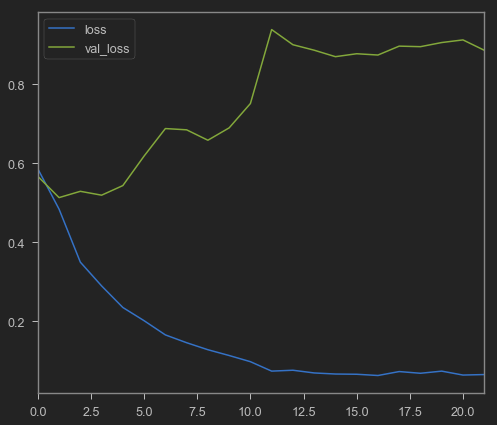

In [112]:
# Visualize loss and val_loss

pd.DataFrame(metrics).plot(y=["loss","val_loss"])

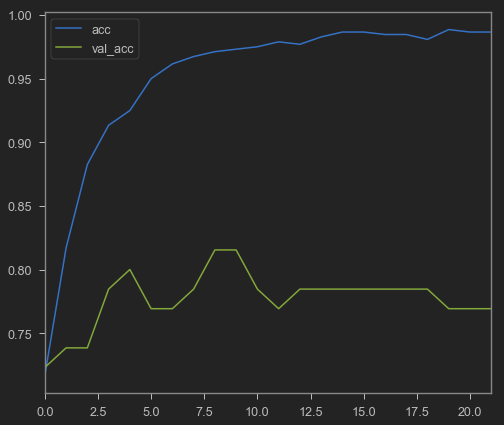

In [113]:
# Visualize accuracy and validation accuracy

pd.DataFrame(metrics).plot(y=["acc","val_acc"])

#### We can see that the validation loss started to decrease sharply after 3 epochs

In [3]:
# Load model

model = load_model('./model/LSTM_TH.h5')

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.


In [16]:
# Evaluate with test set

yhat = model.predict_classes(X_test)
yhat_prob = model.predict_proba(X_test)
report = classification_report(y_test, yhat)
con_mat = confusion_matrix(y_test, yhat, labels=[1,0])
yhat_dummy = to_categorical(yhat)

In [17]:
print(report)

              precision    recall  f1-score   support

           0       0.58      0.65      0.61        17
           1       0.87      0.83      0.85        48

   micro avg       0.78      0.78      0.78        65
   macro avg       0.72      0.74      0.73        65
weighted avg       0.79      0.78      0.79        65



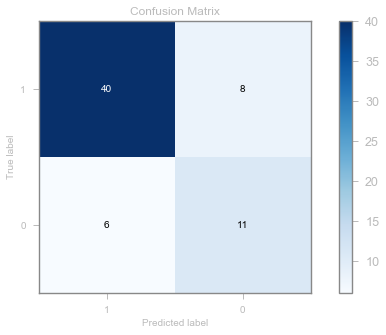

In [18]:
skplt.metrics.plot_confusion_matrix(y_test, yhat, labels=[1,0], figsize=(10,5))

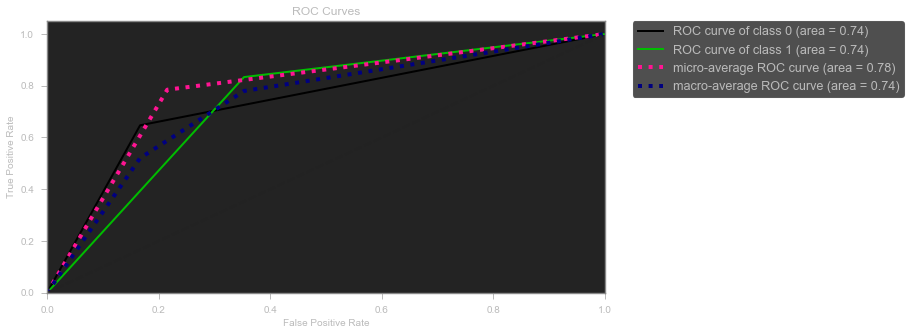

In [19]:
skplt.metrics.plot_roc(y_test, yhat_dummy, text_fontsize = 'medium', figsize = (10,5))
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0)
plt.show()

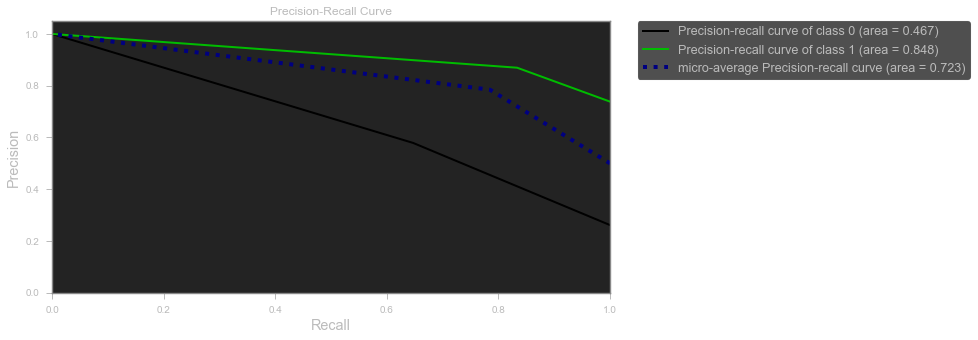

In [20]:
skplt.metrics.plot_precision_recall(y_test, yhat_dummy, text_fontsize = 'medium', figsize = (10,5))
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0)
plt.show()

These figures show that the model has good prediction for class 1 (positive comment) but predict badly for class 0 (negative comment). The model can be improve by having more negative comments.

### Analysis on Error

In [24]:
# Create dataframe to do analysis on error
df_X_test_copy = df_X_test.copy()

# Reset index
df_X_test_copy.reset_index(drop=True, inplace=True)

# Insert new column yhat
df_X_test_copy["yhat"] = pd.DataFrame(yhat, columns=['yhat'])

# Compare y ground truth with yhat
df_X_test_copy['test'] = df_X_test_copy["score"] != df_X_test_copy["yhat"]

# Show comments
df_X_test_copy.loc[df_X_test_copy["test"] == True, ["comment_th", 'score', 'yhat', 'hospital']]

,comment_th,score,yhat,hospital
1,ถามอะไรหน่อยได้ไหม พอจะรู้จักใครที่เขามีปัญหาสุขภาพ เช่น คนที่อยากจะลดน้ำหนัก กระชับสัดส่วน ต้นแขนต้นขา หน้าท้อง เพิ่มน้ำหนัก อยากผิวขาว มีออร่า สิว เพิ่มหน้าอก อยากเพิ่มนาด ใหญ่ ยาว อึด ทน นาน เพิ่มน้ำ เพิ่มรอบให้ยาวนาน และคนที่มีปัญหาเรื่องการขับถ่าย อย่าง-วันถ่ายที่และญาติผู้ใหญ่เป็นโรค ประจำ เช่นความดันเบาหวานโรคหัวใจโรคมะเร็ง ถ้ามีช่วยแนะนำให้ด้วยนะ ขอบคุณมากๆๆจร้า,1,0,rama
6,การรักษาถือว่าโอเครนะคร๊ แต่เรื่องที่จอดรถควรปรับปรุงเป้นอย่างมาก เพราะผู้ป่วยมาหาหมอแต่ละทีไม่มีที่จอดรถเลย ในโรงบาลก้อบอกให้จอดได้แต่เจ้าหน้า ตายห่าพอดีแระ คนป่วยรึญาติมาเยี่ยมผู้ป่วยต้องไปรถไว้ปั้มน้ำมันแล้วนั่งแท็กซี่มา แล้วจะมารถส่วนตัวไว้เพื่อ โรงบาลก้อใหญ่ แระ รวย แนะนำนะคร๊ทำที่รถเหมือนในห้างเลยคร๊ ทำหลายๆชั้นเพื่อรองรับคุนหมอ พยาบาลแระเจ้าหน้า ผู้ป่วยไม่ต้องสนใจหรอกคร๊,0,1,rama
9,คนไข้จำนวนมาก อาจต้องรอนานหน่อย แต่การรักษาเป็นมาตรฐาน,1,0,siriraj
11,ตั้งแต่ ปีที่ผ ่านมาบริการดีมากแต่ระยะหลังนี้หล้าช้ามากค่ะ,1,0,rama
15,คนเยอะรอนานหน่อยแต่ก็ดี,1,0,chula
23,ด้วยขื่อเสียงที่มีมายาวนาน และมีคนใกล้ชิดเข้ารับการรักษา และดิฉันก็เป็นหนึ่งในผู้บริจาคให้มูลนิธิรามาธิบดีมาอย่างยาวนาน แต่พอคุณพ่อเข้ารับการรักษาในห้องอุบัติเหตุและฉุกเฉิน ไม่ได้รับการดูแลอย่างที่ควร ผนวกกับไม่มีห้อง เจ้าหน้าที่ โดยเฉพาะพยาบาลและเจ้ากน้าที่พูดจาไม่ดีเลย สุดท้ายต้องย้ายโรงพยาบาลค่ะ,0,1,rama
31,คุณภาพให้ที่เลยค่ะ >,1,0,chula
48,ขอบคุณที่ดูแลร่างกายฉันตลอดปีก็มาที่นี่ดูแลกันที่นี่คลอดก็ที่นี่คนทุกคนต้องมีการซ่อมแซม ขอให้พระราชินีทั้งสามพระองค์ทรงพระเจริญ ผู้ก่อตั้งโรงบยาบาล,0,1,chula
49,เรารักษาที่นี้ครั้งแรกด้วยอาการซึมเศร้า พยาบาลยิ้ม น่ารัก พูดเพราะทุกๆคนเลย เขาไม่แสดงออกเลยว่าหงุดหงิด หรือรำคาญผู้ป่วยที่แสดงออกเสียงดัง หรือควบคุมไม่ได้ เราไม่รู้สึกว่าตัวเองเป็นคนแปลกแยก กลับมีเพื่อนคุยในเรื่องคล้ายๆกัน ระหว่างรอคุณหมอ คุณหมอทุกท่านใจดีมากๆเลย เภสัชก็น่ารัก เราเลือกไม่ผิดจริงๆที่รักษาที่นี้ เรารักศิริราชมากๆเลย,1,0,siriraj
50,การบริการของหมอและพยาบาลดีมาก แต่ควรปรับปรุงคือเรื่องเวลา รอตรวจนานมาก รอรับยานานมากเช่นกันค่ะ,1,0,rama


The error produced the model are due to:-
1. Some of the comments are ambigious that contain both positive and negative sentiment (6, 9, 11, 15, 50)
2. Some comments are question not sentiment (1, 59)
3. Some comments are incorrectly predicted (23, 48, 49, 55, 62, 63)

From the analysis, the model could be confused by having comments that contain both positive and negative sentiment. Which could lead to incorrect prediction.

In [56]:
neg_comments = df_X_test_copy[(df_X_test_copy['yhat']==0) & (df_X_test_copy['score']==0)]

In [463]:
neg_comments["sent_token"] = df_X_test_copy["comment_th"].apply(lambda x: sent_tokenize(x, engine='deepcut'))

E:\Users\User\Anaconda3\envs\keras\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [467]:
# get tokenized sentence

df_X_test_copy["token_sent"] = df_X_test_copy["comment_th"].apply(lambda x: sent_tokenize(x, engine='deepcut'))

In [469]:
df_X_test_copy.head()

,comment_th,score,hospital,token,length,yhat,test,token_sent,token_sent_POS,token_sent_POS_NCMN
0,หมอและพยาบาล มีจิตใจที่เสียสละให้การรักษาคนไข้อย่างสุดความสามารถ และการจัดระบบที่นี่ดีมากค่ะ,1,rama,"[หมอ, และ, พยาบาล, , มี, จิตใจ, ที่, เสียสละ, ให้, การรักษา, คนไข้, อย่างสุดความสามารถ, , และ, การจัดระบบ, ที่นี่, ดีมาก, ค่ะ]",18,1,False,"[หมอและพยาบาล, มีจิตใจที่เสียสละให้การรักษาคนไข้อย่างสุดความสามารถ, และการจัดระบบที่นี่ดีมากค่ะ]","[[(หมอและพยาบาล, NCMN), (มีจิตใจที่เสียสละให้การรักษาคนไข้อย่างสุดความสามารถ, NCMN), (และการจัดระบบที่นี่ดีมากค่ะ, NCMN)]]","[(หมอและพยาบาล, NCMN), (มีจิตใจที่เสียสละให้การรักษาคนไข้อย่างสุดความสามารถ, NCMN), (และการจัดระบบที่นี่ดีมากค่ะ, NCMN)]"
1,ถามอะไรหน่อยได้ไหม พอจะรู้จักใครที่เขามีปัญหาสุขภาพ เช่น คนที่อยากจะลดน้ำหนัก กระชับสัดส่วน ต้นแขนต้นขา หน้าท้อง เพิ่มน้ำหนัก อยากผิวขาว มีออร่า สิว เพิ่มหน้าอก อยากเพิ่มนาด ใหญ่ ยาว อึด ทน นาน เพิ่มน้ำ เพิ่มรอบให้ยาวนาน และคนที่มีปัญหาเรื่องการขับถ่าย อย่าง-วันถ่ายที่และญาติผู้ใหญ่เป็นโรค ประจำ เช่นความดันเบาหวานโรคหัวใจโรคมะเร็ง ถ้ามีช่วยแนะนำให้ด้วยนะ ขอบคุณมากๆๆจร้า,1,rama,"[ถาม, อะไร, หน่อย, ได้, ไหม, , พอ, จะ, รู้จัก, ใคร, ที่, เขา, มีปัญหา, สุขภาพ, , เช่น, , คน, ที่, อยาก, จะ, ลดน้ำหนัก, , กระชับ, สัดส่วน, , ต้นแขน, ต้นขา, , หน้าท้อง, , เพิ่ม, น้ำหนัก, , อยาก, ผิวขาว, , มี, ออ, ร่า, , สิว, , เพิ่ม, หน้าอก, , อยาก, เพิ่ม, นาด, , ใหญ่, , ยาว, , อึด, , ทน, , นาน, , เพิ่ม, น้ำ, , เพิ่ม, รอบ, ให้, ยาวนาน, , และ, คน, ที่, มีปัญหา, เรื่อง, การ, ขับถ่าย, , อย่าง, -, วัน, ถ่าย, ที่, และ, ญาติผู้ใหญ่, เป็นโรค, , ประจำ, , เช่น, ความดัน, เบาหวาน, โรคหัวใจ, โรคมะเร็ง, , ถ้า, มี, ช่วย, แนะนำ, ให้, ด้วย, นะ, ...]",105,0,True,"[ถามอะไรหน่อยได้ไหม, พอจะรู้จักใครที่เขามีปัญหาสุขภาพ, เช่น, คนที่อยากจะลดน้ำหนัก, กระชับสัดส่วน, ต้นแขนต้นขา, หน้าท้อง, เพิ่มน้ำหนัก, อยากผิวขาว, มีออร่า, สิว, เพิ่มหน้าอก, อยากเพิ่มนาด, ใหญ่, ยาว, อึด, ทน, นาน, เพิ่มน้ำ, เพิ่มรอบให้ยาวนาน, และคนที่มีปัญหาเรื่องการขับถ่าย, อย่าง-วันถ่ายที่และญาติผู้ใหญ่เป็นโรค, ประจำ, เช่นความดันเบาหวานโรคหัวใจโรคมะเร็ง, ถ้ามีช่วยแนะนำให้ด้วยนะ, ขอบคุณมากๆๆจร้า]","[[(ถามอะไรหน่อยได้ไหม, NCMN), (พอจะรู้จักใครที่เขามีปัญหาสุขภาพ, NCMN), (เช่น, RPRE), (คนที่อยากจะลดน้ำหนัก, NCMN), (กระชับสัดส่วน, NCMN), (ต้นแขนต้นขา, NCMN), (หน้าท้อง, NCMN), (เพิ่มน้ำหนัก, VACT), (อยากผิวขาว, NCMN), (มีออร่า, NCMN), (สิว, NCMN), (เพิ่มหน้าอก, NCMN), (อยากเพิ่มนาด, NCMN), (ใหญ่, VATT), (ยาว, VATT), (อึด, PNTR), (ทน, VACT), (นาน, ADVN), (เพิ่มน้ำ, NCMN), (เพิ่มรอบให้ยาวนาน, NCMN), (และคนที่มีปัญหาเรื่องการขับถ่าย, NCMN), (อย่าง-วันถ่ายที่และญาติผู้ใหญ่เป็นโรค, NCMN), (ประจำ, VATT), (เช่นความดันเบาหวานโรคหัวใจโรคมะเร็ง, NCMN), (ถ้ามีช่วยแนะนำให้ด้วยนะ, ADVN), (ขอบคุณมากๆๆจร้า, NCMN)]]","[(ถามอะไรหน่อยได้ไหม, NCMN), (พอจะรู้จักใครที่เขามีปัญหาสุขภาพ, NCMN), (คนที่อยากจะลดน้ำหนัก, NCMN), (กระชับสัดส่วน, NCMN), (ต้นแขนต้นขา, NCMN), (หน้าท้อง, NCMN), (อยากผิวขาว, NCMN), (มีออร่า, NCMN), (สิว, NCMN), (เพิ่มหน้าอก, NCMN), (อยากเพิ่มนาด, NCMN), (เพิ่มน้ำ, NCMN), (เพิ่มรอบให้ยาวนาน, NCMN), (และคนที่มีปัญหาเรื่องการขับถ่าย, NCMN), (อย่าง-วันถ่ายที่และญาติผู้ใหญ่เป็นโรค, NCMN), (เช่นความดันเบาหวานโรคหัวใจโรคมะเร็ง, NCMN), (ขอบคุณมากๆๆจร้า, NCMN)]"
2,ดีมากคะ,1,chula,"[ดีมาก, คะ]",2,1,False,[ดีมากคะ],"[[(ดีมากคะ, NCMN)]]","[(ดีมากคะ, NCMN)]"
3,ประทับใจค่ะ เป็นรพรัฐ ที่มีการบริการเอาใจใส่ดีมากกว่าที่อื่นๆ พยาบาลใจดีมากๆค่ะ ถึงแม้จะมีนักศึกษาแพทย์ที่มาฝึกเยอะ แอบมีคุยเล่นกันเป็นกลุ่มบ้าง แต่ในเวลาตรวจก็ซักประวัติค่อนข้างระเอียดดีค่ะ สถานพยาบาลสะอาดทันสมัย มีร้านอาหารต่างๆภายในรพ อยู่ใจกลางเมืองด้วย ครบครันดีค่ะ,1,rama,"[ประทับใจ, ค่ะ, , เป็น, รพ, รัฐ, , ที่, มี, การ, บริการ, เอาใจใส่, ดี, มากกว่า, ที่, อื่นๆ, , พยาบาล, ใจ, ดีมาก, ๆ, ค่ะ, , ถึงแม้, จะ, มี, นักศึกษา, แพทย์, ที่มา, ฝึก, เยอะ, , แอบ, มี, คุย, เล่น, กัน, เป็น, กลุ่ม, บ้าง, , แต่, ใน, เวลา, ตรวจ, ก็, ซัก, ประวัติ, ค่อนข้าง, ระ, เอียด, ดี, ค่ะ, , สถานพยาบาล, สะอาด, ทันสมัย, , มี, ร้านอาหาร, ต่างๆ, ภายใน, รพ, , อยู่, ใจ, กลางเมือง, ด้วย, , ครบครัน, ดี, ค่ะ]",72,1,False,"[ประทับใจค่ะ, เป็นรพรัฐ, ที่มีการบริการเอาใจใส่ดีมากกว่าที่อื่นๆ, พยาบาลใจดีมากๆค่ะ, ถึงแม้จะมีนักศึกษาแพทย์ที่มาฝ

In [470]:
# perform POS on sentence
df_X_test_copy["token_sent_POS"] = df_X_test_copy["token_sent"].apply(lambda x : pos_tag_sents([x]))
df_X_test_copy["token_sent_POS"].tail()

60    [[(สถานที่คับแคบเมื่อเทียบกับจำนวนคนที่ใช้บริการ, NCMN), (แต่บุคคลากรเต็มที่กับการบริการมาก, DDAN), (ถึงแม้คนจะเยอะทุกวัน, ADVN), (ทุกเวลา, DONM), (แต่คุณหมอ, VACT), (พยาบาล, NCMN), (เจ้าหน้าที่ก็พูดจากับคนไข้ดีค่ะ, NCMN), (ถึงแม้บางคนจะหงุดหงิดบ้างแต่โดยรวมแล้วน่ารักทุกคนค่ะ, NCMN)]]                                                                                                                                                                                                                                                                                               
61    [[(จะกี่ครั้ง, JCRG), (จะกี่หน, NCMN), (ต้องใช้ความอดทน, NCMN), (และ, JCRG), (ทำใจ, NCMN), (ทุกครั้งที่มา, NCMN), (ไม่ว่าตะพยายามคิดในแง่ดีแค่ไหนก็ไม่สามารถ, NCMN), (ทำให้ความรู้สึกดีขึ้นเลย, VACT), (ได้แต่คิดผิดที่กู, NCMN), (เสือกมาที่นี่เอง, PDMN), (ก็รู้ว่าไม่ได้มีเพียงแต่เรา, NCMN), (ทุกคนก็ใช้ความอดทนแต่ตลอดปีกว่าที่เพียรมารักษาที่นี่, DDAN), (จากความหวัง, VACT), (กลายเป็นความฝังใจและฝังยันรากลึก, NCMN), (

In [175]:
# get only noun sentence
search_pos = 'NCMN'

sent_pos = []
for i in range(len(df_X_test_copy["token_sent_POS"])):
    sent = []
    for j in range(len(df_X_test_copy["token_sent_POS"][i])):
        group = []
        for k in range(len(df_X_test_copy["token_sent_POS"][i][j])):
            if search_pos in df_X_test_copy["token_sent_POS"][i][j][k]:
                group.append(df_X_test_copy["token_sent_POS"][i][j][k])
        sent.append(group)
    sent_pos.append(sent)

In [472]:
# insert into dataframe

df_X_test_copy["token_sent_POS_NCMN"] = pd.DataFrame(sent_pos)

In [473]:
df_X_test_copy[df_X_test_copy['yhat']==0].head()

,comment_th,score,hospital,token,length,yhat,test,token_sent,token_sent_POS,token_sent_POS_NCMN
1,ถามอะไรหน่อยได้ไหม พอจะรู้จักใครที่เขามีปัญหาสุขภาพ เช่น คนที่อยากจะลดน้ำหนัก กระชับสัดส่วน ต้นแขนต้นขา หน้าท้อง เพิ่มน้ำหนัก อยากผิวขาว มีออร่า สิว เพิ่มหน้าอก อยากเพิ่มนาด ใหญ่ ยาว อึด ทน นาน เพิ่มน้ำ เพิ่มรอบให้ยาวนาน และคนที่มีปัญหาเรื่องการขับถ่าย อย่าง-วันถ่ายที่และญาติผู้ใหญ่เป็นโรค ประจำ เช่นความดันเบาหวานโรคหัวใจโรคมะเร็ง ถ้ามีช่วยแนะนำให้ด้วยนะ ขอบคุณมากๆๆจร้า,1,rama,"[ถาม, อะไร, หน่อย, ได้, ไหม, , พอ, จะ, รู้จัก, ใคร, ที่, เขา, มีปัญหา, สุขภาพ, , เช่น, , คน, ที่, อยาก, จะ, ลดน้ำหนัก, , กระชับ, สัดส่วน, , ต้นแขน, ต้นขา, , หน้าท้อง, , เพิ่ม, น้ำหนัก, , อยาก, ผิวขาว, , มี, ออ, ร่า, , สิว, , เพิ่ม, หน้าอก, , อยาก, เพิ่ม, นาด, , ใหญ่, , ยาว, , อึด, , ทน, , นาน, , เพิ่ม, น้ำ, , เพิ่ม, รอบ, ให้, ยาวนาน, , และ, คน, ที่, มีปัญหา, เรื่อง, การ, ขับถ่าย, , อย่าง, -, วัน, ถ่าย, ที่, และ, ญาติผู้ใหญ่, เป็นโรค, , ประจำ, , เช่น, ความดัน, เบาหวาน, โรคหัวใจ, โรคมะเร็ง, , ถ้า, มี, ช่วย, แนะนำ, ให้, ด้วย, นะ, ...]",105,0,True,"[ถามอะไรหน่อยได้ไหม, พอจะรู้จักใครที่เขามีปัญหาสุขภาพ, เช่น, คนที่อยากจะลดน้ำหนัก, กระชับสัดส่วน, ต้นแขนต้นขา, หน้าท้อง, เพิ่มน้ำหนัก, อยากผิวขาว, มีออร่า, สิว, เพิ่มหน้าอก, อยากเพิ่มนาด, ใหญ่, ยาว, อึด, ทน, นาน, เพิ่มน้ำ, เพิ่มรอบให้ยาวนาน, และคนที่มีปัญหาเรื่องการขับถ่าย, อย่าง-วันถ่ายที่และญาติผู้ใหญ่เป็นโรค, ประจำ, เช่นความดันเบาหวานโรคหัวใจโรคมะเร็ง, ถ้ามีช่วยแนะนำให้ด้วยนะ, ขอบคุณมากๆๆจร้า]","[[(ถามอะไรหน่อยได้ไหม, NCMN), (พอจะรู้จักใครที่เขามีปัญหาสุขภาพ, NCMN), (เช่น, RPRE), (คนที่อยากจะลดน้ำหนัก, NCMN), (กระชับสัดส่วน, NCMN), (ต้นแขนต้นขา, NCMN), (หน้าท้อง, NCMN), (เพิ่มน้ำหนัก, VACT), (อยากผิวขาว, NCMN), (มีออร่า, NCMN), (สิว, NCMN), (เพิ่มหน้าอก, NCMN), (อยากเพิ่มนาด, NCMN), (ใหญ่, VATT), (ยาว, VATT), (อึด, PNTR), (ทน, VACT), (นาน, ADVN), (เพิ่มน้ำ, NCMN), (เพิ่มรอบให้ยาวนาน, NCMN), (และคนที่มีปัญหาเรื่องการขับถ่าย, NCMN), (อย่าง-วันถ่ายที่และญาติผู้ใหญ่เป็นโรค, NCMN), (ประจำ, VATT), (เช่นความดันเบาหวานโรคหัวใจโรคมะเร็ง, NCMN), (ถ้ามีช่วยแนะนำให้ด้วยนะ, ADVN), (ขอบคุณมากๆๆจร้า, NCMN)]]","[(ถามอะไรหน่อยได้ไหม, NCMN), (พอจะรู้จักใครที่เขามีปัญหาสุขภาพ, NCMN), (คนที่อยากจะลดน้ำหนัก, NCMN), (กระชับสัดส่วน, NCMN), (ต้นแขนต้นขา, NCMN), (หน้าท้อง, NCMN), (อยากผิวขาว, NCMN), (มีออร่า, NCMN), (สิว, NCMN), (เพิ่มหน้าอก, NCMN), (อยากเพิ่มนาด, NCMN), (เพิ่มน้ำ, NCMN), (เพิ่มรอบให้ยาวนาน, NCMN), (และคนที่มีปัญหาเรื่องการขับถ่าย, NCMN), (อย่าง-วันถ่ายที่และญาติผู้ใหญ่เป็นโรค, NCMN), (เช่นความดันเบาหวานโรคหัวใจโรคมะเร็ง, NCMN), (ขอบคุณมากๆๆจร้า, NCMN)]"
4,แผนก #หนวยสิทธิประโยชน์ผู้รับบริการ ชั้น ตรงประตูทางเข้า แยกตึกชัย ควรที่จะปรับปรุง เรื้องบัตรคิว นะครับ อย่าก จะแนะนำ ให้ นำบัตรคิว มาวางก่อน ได้มัย ผู้รับบริการจะได้ ไม่ต้องไปต่อแถวรอครับ บางคน ก็แทรกแถว บางคนก็แซงคิว อย่ากให้เห็นใจคนที่เจารอ อะคับ บางทีบัตรคิว ก็เปลียนตำแหนงวาง บอกเลย แย่มาก บอกเลยเป็นอย่างนีมาหลายปีละ ผมมาก่อน ตี ทึกครั้งเห็นทุกครั้ง ครับ แค่อย่ากแนะนำ,0,rama,"[แผนก, , #ห, นวย, สิทธิประโยชน์, ผู้รับ, บริการ, , ชั้น, , ตรง, ประตู, ทางเข้า, , แยก, ตึก, ชัย, , ควร, ที่จะ, ปรับปรุง, , เรื้อง, บัตร, คิว, , นะ, ครับ, , อย่า, ก, , จะ, แนะนำ, , ให้, , นำ, บัตร, คิว, , มา, วาง, ก่อน, , ได้, มัย, , ผู้รับ, บริการ, จะ, ได้, , ไม่ต้อง, ไป, ต่อ, แถว, รอ, ครับ, , บางคน, , ก็, แทรก, แถว, , บางคน, ก็, แซงคิว, , อย่า, ก, ให้, เห็นใจ, คน, ที่, เจา, รอ, , อะ, คับ, , บางที, บัตร, คิว, , ก็, เปลียน, ตำ, แหนง, วาง, , บอก, เลย, , แย่มาก, , บอก, เลย, เป็น, ...]",124,0,False,"[แผนก, #หนวยสิทธิประโยชน์ผู้รับบริการ, ชั้น, ตรงประตูทางเข้า, แยกตึกชัย, ควรที่จะปรับปรุง, เรื้องบัตรคิว, นะครับ, อย่าก, จะแนะนำ, ให้, นำบัตรคิว, มาวางก่อน, ได้มัย, ผู้รับบริการจะได้, ไม่ต้องไปต่อแถวรอครับ, บางคน, ก็แทรกแถว, บางคนก็แซงคิว, อย่ากให้เห็นใจคนที่เจารอ, อะคับ, บางทีบัตรคิว, ก็เปลียนตำแหนงวาง, บอกเลย, แย่มาก, บอกเลยเป็นอย่างนีมาหลายปีละ, ผมมาก่อน, ตี, ทึกครั้งเห็นทุกครั้ง, ครับ, แค่อย่ากแนะนำ]","[[(แผนก, NCMN), (#หนวยสิทธิประโยชน์ผู้รับบริการ, NCMN), (ชั้น, NCMN), (ตรงประตูทางเข้า, VACT), (แยกตึกชัย, NCMN), (ควรที่จะปรับปรุง, NCMN), (เรื้องบัตรคิว, NCMN), (นะครับ, VACT), (อย่าก, NCMN), (จะแน

### Word Cloud

In [474]:
# store negative sentence that has NCMN POS
neg_list = []

# get index of all yhat that predicted 0
neg_index = df_X_test_copy[df_X_test_copy['yhat']==0].index

for i in neg_index:
    for j in range(len(df_X_test_copy['token_sent_POS_NCMN'][i])):
        neg_list.append(df_X_test_copy['token_sent_POS_NCMN'][i][j][0])

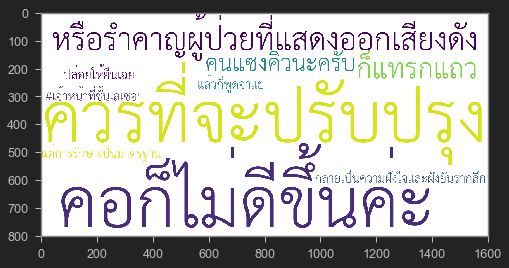

In [475]:
# Random sentence from predicted negative comment
items = random.sample(neg_list,10)
counter_neg_list = Counter(items)

w = WordCloud(font_path='.font\THSarabunNew.ttf',
              width=1600,height=800,mode='RGBA',
              background_color='white', max_words=20).fit_words(counter_neg_list)

plt.imshow(w)
plt.show()

## Model after remove stopwords

In [548]:
df = pd.read_csv(r'./data/all_hosp.csv')
df = df.rename(columns = {'0':"comment_th", 
                          '1':"score",
                          '3':"hospital"})
df.drop(columns='2', inplace=True)

In [549]:
df.head()

,comment_th,score,hospital
0,ผมเคยไปทำเลสิกที่นี้ ดีมากครับตอนนี้ผ่ามาจะ2ปีแล้วยังไม่มีผลค้างเคียงอะไรและราคาก็ถูกดีด้วย ตอนผ่าอาจจะดูน่ากลัวไปซะหน่อย แต่พอถึงเวลาผ่าจริงๆแล้วไม่รู้สึกเจ็บเลยครับ เพราะมีการหยอดยาชาก่อนผ่า,4,rama
1,รักษามาหลายปีแล้วตั้งแต่อายุ14 ตอนนี้จะจบปริญญาตรีแล้ว ตั้งแต่นอนแอดมิดที่ รพ จนหายดีออกมาใช้ชีวิตได้เป็นปกติ โดยเฉพาะคลินิกพรีเมี่ยม ไม่ต้องรอนาน มีความสะดวกรวดเร็วทุกขั้นตอนตั้งแต่จ่ายเงินไปถึงจ่ายยา ค่ารักษาไม่ได้แพงเกินไปเมื่อเทียบเท่ากับเอกชนหลายๆที่ บริการดีมากๆ คุณหมอดูแลเอาใจใส่ดี อยากให้ทุกคนมารักษาที่นี่,5,rama
2,ที่ตึกพระเทพชั้น 2 สถานที่เครื่องมือดูทันสมัย \rแต่ที่ห้องวัดความดัน มีคนที่วัด(คิดว่าไม่ใช่พยาบาลเพราะใส่ชุดสีม่วง) ชอบดุคนที่มาวัด พูดเสียงแข็งใส่คนที่มาวัดความดัน ทั้งๆที่พยาบาลอีกคนที่ใส่ชุดพยาบาลพูดเพราะ อยากให้ปรับปรุง \r มาหาหมอที่แผนกศัลยกรรม อาจารย์หมอตรวตแล้วบอกต้องผ่าตัด บอกแค่ว่าต้องผ่าตัดถึงจะหายตอนนั้นช็อคเรื่องผ่าตัดอยู่เลยไม่ได้ถามอะไรเลย แล้วหมอกก็ไปเลยไม่ได้บอกว่าจริงๆเป็นอะไร ระยะไหน (ริดสีดวง) แล้วก็นัดวันผ่า พยาบาลที่นัดคิวก็ไม่สนเวลาเราทวนสิ่งที่บอกมาว่าถูกต้องไหม บอกแค่ว่าตามนั้นแหละ สรุปแล้วเหมือนจะดีแต่รอดูช่วงผ่าตัดก่อน,3,rama
3,"Its a public hospital so service is bad (nurses are completely unfriendly and doctors have god complex plus horrifying bed side manner) but they will keep you alive (nothing to do with quality of life) with decent drug collection. Young doctors are generally very friendly but they are busy all the time due to the amount of patients (like canned tuna) so don't expect them to spend too much time diagnosing you. You have to come early in the morning to ensure you're in queue and the wait 1-2 (bad days) hours behind schedule to get to see the doctor for < 15 min or less (all together door to door 8-9hrs). \r Additionally you can call all the 8 numbers on the websites from normal clinic to Premium and wait 15 minutes on each number just for them to hang up on you or divert you elsewhere then hang up on you.....\r Worst are the guys doing the schedule because they are very consistent in demonstrating the inability to manage schedules (or not) because you will ""always"" have to wait 1-2 hours ""after"" your appointment schedule to see the doctor but they also cant tell you that so you cant go anywhere and have to hang around the front door. \r In the better days you will get to sit inside the doctor's room to wait because the doctor is no where to be found and nobody will know when he/she will come back. If you ask the nurse they will give you the ""i dont know and I couldnt care less"" look and turn away in annoyance. \r But yes, they have great ability (the doctors definitely know what they are doing) to use ur tax fund to keep you alive, two stars for that!!\r Updated review for ER: The best ER u can probably find in Bangkok as they are 24hrs fully staffed with specialty doctors (not just general doctors like other hospitals during off business hours). They are jammed packed but they are fully equipped and by that I mean they have CT scanner in the ER room - this is not something we find everywhere. Doctors know what they are doing and fully equipped with the tools to keep u alive.\r Even better update:\r Just decided to go for full blown annual health check at Rama (Feb 2016) and here are the pros and cons:\r Cons:\rAs a foreigner who pays tax in Thailand ur sort of half screwed. They are not equipped to handle foreign language so if u cant google medical terms properly u might go home thinking everything is perfect when its not...A less life threatening case is that if u pay tax to Thailand ur entitled to Thai citizen price 30% less or so which is surprisingly logical BUT not without flaws...u have to bring the ""physical"" ""original"" tax receipt from revenue dept to show then which u DONT get if u file electronically....so....who does NOT file electronically? I dont know one....maybe my parents but they're 75....\r Pros:\rOmg its a very pleasant surprise that this clinic operates with the speed, manner, and professionalism that 

### Preprocess

In [553]:
# get stopwords from pythainlp

stopwords = corpus.thai_stopwords()

In [554]:
# create function to remove stopwords from tokenized word

def remove_stopword(i):
    comment = []
    word = word_tokenize(i)
    for j in word:
        if j not in stopwords:
            comment.append(j)
    return comment

In [555]:
# remove stopwords

df["token_remove_stopwords"] = df["comment_th"].apply(lambda x: remove_stopword(x))

In [556]:
# Transform score into binary

df.score = df.score.apply(pos_neg)

In [557]:
df.head()

,comment_th,score,hospital,token_remove_stopwords
0,ผมเคยไปทำเลสิกที่นี้ ดีมากครับตอนนี้ผ่ามาจะ2ปีแล้วยังไม่มีผลค้างเคียงอะไรและราคาก็ถูกดีด้วย ตอนผ่าอาจจะดูน่ากลัวไปซะหน่อย แต่พอถึงเวลาผ่าจริงๆแล้วไม่รู้สึกเจ็บเลยครับ เพราะมีการหยอดยาชาก่อนผ่า,1,rama,"[ผม, ทำ, เลสิก, , ดีมาก, ตอนนี้, ผ่า, 2, ปี, ไม่มีผล, ค้าง, เคียง, ราคา, ดี, , ตอน, ผ่า, ดู, น่ากลัว, , เวลา, ผ่า, รู้สึก, เจ็บ, , การหยอด, ยาชา, ผ่า]"
1,รักษามาหลายปีแล้วตั้งแต่อายุ14 ตอนนี้จะจบปริญญาตรีแล้ว ตั้งแต่นอนแอดมิดที่ รพ จนหายดีออกมาใช้ชีวิตได้เป็นปกติ โดยเฉพาะคลินิกพรีเมี่ยม ไม่ต้องรอนาน มีความสะดวกรวดเร็วทุกขั้นตอนตั้งแต่จ่ายเงินไปถึงจ่ายยา ค่ารักษาไม่ได้แพงเกินไปเมื่อเทียบเท่ากับเอกชนหลายๆที่ บริการดีมากๆ คุณหมอดูแลเอาใจใส่ดี อยากให้ทุกคนมารักษาที่นี่,1,rama,"[รักษา, ปี, อายุ, 14, , ตอนนี้, จบ, ปริญญาตรี, , นอน, แอด, มิด, , รพ, , หาย, ดี, ออกมา, ใช้ชีวิต, เป็นปกติ, , โดยเฉพาะ, คลินิก, พรีเมี่ยม, , ไม่ต้อง, รอ, , ความสะดวก, ขั้นตอน, จ่าย, เงิน, จ่าย, ยา, , ค่ารักษา, ไม่ได้, แพง, เกินไป, เทียบ, เอกชน, , บริการ, ดีมาก, , คุณหมอ, ดูแลเอาใจใส่, ดี, , รักษา, ที่นี่]"
2,ที่ตึกพระเทพชั้น 2 สถานที่เครื่องมือดูทันสมัย \rแต่ที่ห้องวัดความดัน มีคนที่วัด(คิดว่าไม่ใช่พยาบาลเพราะใส่ชุดสีม่วง) ชอบดุคนที่มาวัด พูดเสียงแข็งใส่คนที่มาวัดความดัน ทั้งๆที่พยาบาลอีกคนที่ใส่ชุดพยาบาลพูดเพราะ อยากให้ปรับปรุง \r มาหาหมอที่แผนกศัลยกรรม อาจารย์หมอตรวตแล้วบอกต้องผ่าตัด บอกแค่ว่าต้องผ่าตัดถึงจะหายตอนนั้นช็อคเรื่องผ่าตัดอยู่เลยไม่ได้ถามอะไรเลย แล้วหมอกก็ไปเลยไม่ได้บอกว่าจริงๆเป็นอะไร ระยะไหน (ริดสีดวง) แล้วก็นัดวันผ่า พยาบาลที่นัดคิวก็ไม่สนเวลาเราทวนสิ่งที่บอกมาว่าถูกต้องไหม บอกแค่ว่าตามนั้นแหละ สรุปแล้วเหมือนจะดีแต่รอดูช่วงผ่าตัดก่อน,0,rama,"[ตึก, พระ, เทพ, ชั้น, , 2, , สถานที่, เครื่องมือ, ดู, ทันสมัย, , \r, ห้อง, วัด, ความดัน, , คน, ที่วัด, (, พยาบาล, ใส่, ชุด, สีม่วง, ), , ชอบ, ดุ, คน, ที่มา, วัด, , เสียงแข็ง, ใส่, คน, ที่มา, วัด, ความดัน, , พยาบาล, คน, ใส่, ชุด, พยาบาล, , ปรับปรุง, , \r, , มาหา, หมอ, แผนก, ศัลยกรรม, , อาจารย์, หมอ, ตรวต, ผ่าตัด, , ผ่าตัด, หาย, ตอนนั้น, ช็อค, เรื่อง, ผ่าตัด, อยู่เลย, ไม่ได้, ถาม, , หมอก, ไม่ได้, บอ, , , (, ริดสีดวง, ), , แล้วก็, นัด, ผ่า, , พยาบาล, นัด, คิว, ไม่สน, เวลา, ทวน, ไหม, , นั้นแหละ, , สรุป, เหมือน, ดีแต่, รอ, ดู, ผ่าตัด]"
3,"Its a public hospital so service is bad (nurses are completely unfriendly and doctors have god complex plus horrifying bed side manner) but they will keep you alive (nothing to do with quality of life) with decent drug collection. Young doctors are generally very friendly but they are busy all the time due to the amount of patients (like canned tuna) so don't expect them to spend too much time diagnosing you. You have to come early in the morning to ensure you're in queue and the wait 1-2 (bad days) hours behind schedule to get to see the doctor for < 15 min or less (all together door to door 8-9hrs). \r Additionally you can call all the 8 numbers on the websites from normal clinic to Premium and wait 15 minutes on each number just for them to hang up on you or divert you elsewhere then hang up on you.....\r Worst are the guys doing the schedule because they are very consistent in demonstrating the inability to manage schedules (or not) because you will ""always"" have to wait 1-2 hours ""after"" your appointment schedule to see the doctor but they also cant tell you that so you cant go anywhere and have to hang around the front door. \r In the better days you will get to sit inside the doctor's room to wait because the doctor is no where to be found and nobody will know when he/she will come back. If you ask the nurse they will give you the ""i dont know and I couldnt care less"" look and turn away in annoyance. \r But yes, they have great ability (the doctors definitely know what they are doing) to use ur tax fund to keep you alive, two stars for that!!\r Updated review for ER: The best ER u can probably find in Bangkok as they are 24hrs fully staffed with specialty doctors (not just general doctors like other hospitals during off business hours). They are jammed packed but they are fully equipped and by that I mean they have

In [558]:
df["comment_remove_stopwords"] = df.token_remove_stopwords.apply(lambda x: ''.join(x))

In [559]:
df.tail()

,comment_th,score,hospital,token_remove_stopwords,comment_remove_stopwords
644,บริการห่วยแตกมากและมากสุดๆ ให้ไปกดบัตรคิว นั่งรอเป็นชั่วโมงสุดท้ายบอกตรวจไม่ทัน #แย่,0,chula,"[บริการ, ห่วยแตก, , กด, บัตร, คิว, , นั่ง, รอ, ชั่วโมง, สุดท้าย, ตรวจ, ไม่ทัน, , #, แย่]",บริการห่วยแตก กดบัตรคิว นั่งรอชั่วโมงสุดท้ายตรวจไม่ทัน #แย่
645,นานเกิ๊น,0,chula,[เกิ๊น],เกิ๊น
646,ฝากครรภ์ที่โรงพยาบาลนี้ทั้ง 2 ท้อง เจ้าหน้าที่ พยาบาล รวมถึงแพทย์เจ้าของไข้ ให้บริการและดูแลเป็นอย่างดีค่ะ,1,chula,"[ฝากครรภ์, โรงพยาบาล, , 2, , ท้อง, , เจ้าหน้าที่, , พยาบาล, , แพทย์, เจ้าของ, ไข้, , ให้บริการ, ดูแล]",ฝากครรภ์โรงพยาบาล 2 ท้อง เจ้าหน้าที่ พยาบาล แพทย์เจ้าของไข้ ให้บริการดูแล
647,อยากทราบว่าจะทำการเลื่อนนัดต้องติดต่อที่ใหนค๊,1,chula,"[ทราบ, ทำการ, เลื่อนนัด, ติดต่อ, ใหนค๊]",ทราบทำการเลื่อนนัดติดต่อใหนค๊
648,ได้รับบริการที่ดีมาก คนไข้เยอะมาก แต่พยาบาลและเจ้าหน้าที่ขยันขันแข็งทุกคน เห็นแล้วเหนื่อยแทน ขอบคุณคุณหมอสุรินทร์ อัศววิฑูรทิพย์ ที่ให้การรักษามาตลอด เป็นความโชคดีของครอบครัวเราที่ได้รักษากับคุณหมอ กราบขอบพระคุณค่ะ,1,chula,"[บริการ, ดีมาก, , คนไข้, , พยาบาล, เจ้าหน้าที่, ขยันขันแข็ง, , เหนื่อย, แทน, , ขอบคุณ, คุณหมอ, สุรินทร์, , อัศว, วิ, ฑูร, ทิพย์, , การรักษา, , ความโชคดี, ครอบครัว, รักษา, คุณหมอ, , กราบ, ขอบพระคุณ]",บริการดีมาก คนไข้ พยาบาลเจ้าหน้าที่ขยันขันแข็ง เหนื่อยแทน ขอบคุณคุณหมอสุรินทร์ อัศววิฑูรทิพย์ การรักษา ความโชคดีครอบครัวรักษาคุณหมอ กราบขอบพระคุณ


### Tokenization

In [560]:
# Use tokenization from pythainlp

df["token_no_stopwords"] = df.comment_remove_stopwords.apply(word_tokenize) # create new column with a list of Thai tokenized word

corpus = [df.token_no_stopwords[i][j] for i in range(len(df.token_no_stopwords)) for j in range(len(df.token_no_stopwords[i]))]
unique_word = list(set(corpus)) # create list of unique word
unique_word_count = len(unique_word) # count unique word

tokenizer = Tokenizer(num_words=unique_word_count+1) 
tokenizer.fit_on_texts(df.token_no_stopwords.values) # fit the Thai word

df["length_no_stopwords"] = [len(i) for i in df.token_no_stopwords]
max_length = max([len(i) for i in df.token_no_stopwords]) # find the maximum length of the comment
mean_length = int(round(statistics.mean([len(i) for i in df.token_no_stopwords]),0))

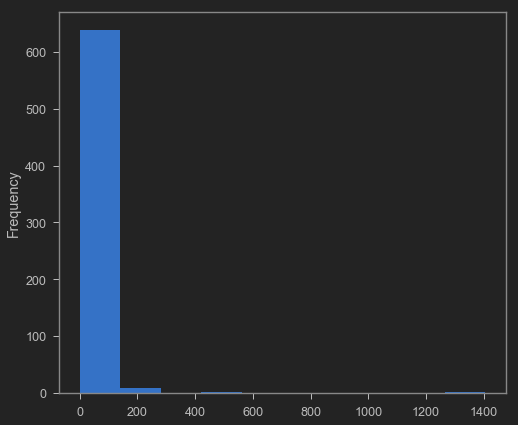

In [561]:
# Visualize the length of words in each comments
# To deicide how much input length should be use in the model

df["length_no_stopwords"].plot(kind='hist')

Mean length: 32


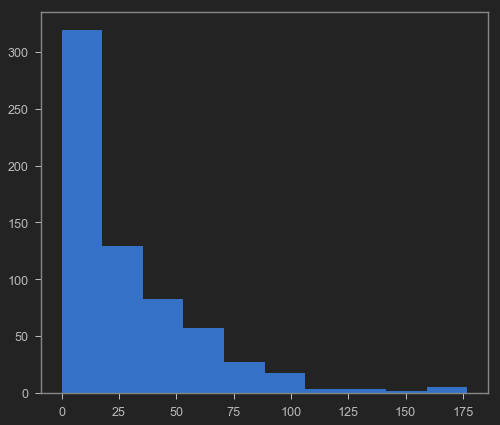

In [562]:
# The length of comments are mostly around 0-100 words
# Visualize the length of words for comment that has less than 200 words

plt.hist(df[df["length_no_stopwords"] <= 200]["length_no_stopwords"])
print("Mean length:",mean_length)

The data shows that the length of words is mostly 20 words in each comment. So, we could use mean length as the input length in the model.

### Build Train Test Dataset

In [563]:
df_X_train, X, y_train, y = train_test_split(
        df, df.score, test_size=0.2, random_state=28, stratify=df.score) 

# create X_validate and X_test using 10% of the dataset, respectively
df_X_validate, df_X_test, y_validate, y_test = train_test_split(
        X, y, test_size=0.5, random_state=28, stratify=y) 

# convert the token into sequence for padding
X_train = tokenizer.texts_to_sequences(df_X_train['token_no_stopwords'].values)
X_test = tokenizer.texts_to_sequences(df_X_test['token_no_stopwords'].values)
X_validate = tokenizer.texts_to_sequences(df_X_validate['token_no_stopwords'].values)

# padd all sequences into the same length
X_train = pad_sequences(X_train, mean_length)
X_test = pad_sequences(X_test, mean_length)
X_validate = pad_sequences(X_validate, mean_length)

# create dummy variable that will be use in Keras
y_train_dummy = pd.get_dummies(y_train) 
y_validate_dummy = pd.get_dummies(y_validate)
y_test_dummy = pd.get_dummies(y_test)

### Model Hypterparameters tuning

In [564]:
# Use sigmoid as the last activation function because the output is binary

np.random.seed(28)
set_random_seed(28)

embed_dim = 100 # number of dimension for each token

# create function of the LSTM model to search for optimal parameters
def create_model_sigmoid(lstm_out=8, lstm_out2=8, lstm_out3=8, lstm_out4 = 8,
                         dropout_rate=0.1, hidden=0, hidden2=0, hidden3=0):
    model = Sequential()
    model.add(Embedding(unique_word_count+1, embed_dim, input_length = mean_length))
    for layer in range(hidden):
        model.add((CuDNNLSTM(lstm_out, return_sequences=True)))
        for layer in range(hidden2):
            model.add((CuDNNLSTM(lstm_out2, return_sequences=True)))
            for layer in range(hidden3):
                model.add((CuDNNLSTM(lstm_out3, return_sequences=True)))
    model.add((CuDNNLSTM(lstm_out4)))
    model.add(Dropout(dropout_rate))
    model.add(Dense(1,activation='sigmoid'))
    model.compile(loss = 'binary_crossentropy', optimizer='RMSprop', metrics = ['accuracy'])
    return model

model_sigmoid = KerasClassifier(build_fn=create_model_sigmoid, verbose=1, epochs=100)

In [570]:
# list of value for parameters search

lstm_out = [8,16]
lstm_out2 = [8,16]
lstm_out3 = [8,16,32]
lstm_out4 = [8,16,32]
dropout_rate = [0.3, 0.4, 0.5]
batch_size = [8]
hidden = [0,1,2]
hidden2 = [0,1,2]
hidden3 = [0,1,2]

param_grid = dict(lstm_out=lstm_out,
                  lstm_out2=lstm_out2,
                  lstm_out3=lstm_out3,
                  lstm_out4=lstm_out4,
                  hidden = hidden,
                  hidden2 = hidden2,
                  hidden3 = hidden3,
                  dropout_rate=dropout_rate, 
                  batch_size=batch_size)

# Random Search
grid = RandomizedSearchCV(estimator=model_sigmoid, 
                          param_distributions=param_grid,
                          scoring="accuracy",
                          cv=ShuffleSplit(test_size=0.10, random_state=28, n_splits=1))


np.random.seed(28)
set_random_seed(28)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10, verbose=1, mode='auto', min_delta=0.0001, cooldown=0, min_lr=0)

# get the model with least val_loss
early_stop = EarlyStopping(patience=20, monitor='val_acc', min_delta=0.0001,verbose=1)

start=time()
grid_result = grid.fit(X_train, y_train ,
                       callbacks=[reduce_lr, early_stop],                        
                       validation_data = [X_validate,y_validate])

print("total time:",time()-start)

Train on 467 samples, validate on 65 samples
Epoch 1/100
467/467 [==============================] - ETA: 1:46 - loss: 0.6884 - acc: 0.750 - ETA: 14s - loss: 0.6722 - acc: 0.732 - ETA: 6s - loss: 0.6679 - acc: 0.6923 - ETA: 3s - loss: 0.6656 - acc: 0.693 - ETA: 2s - loss: 0.6507 - acc: 0.717 - ETA: 1s - loss: 0.6270 - acc: 0.746 - ETA: 0s - loss: 0.6219 - acc: 0.740 - ETA: 0s - loss: 0.6183 - acc: 0.737 - ETA: 0s - loss: 0.6130 - acc: 0.734 - 3s 6ms/step - loss: 0.6210 - acc: 0.7216 - val_loss: 0.5812 - val_acc: 0.7231
Epoch 2/100
467/467 [==============================] - ETA: 0s - loss: 0.4393 - acc: 0.750 - ETA: 0s - loss: 0.5769 - acc: 0.678 - ETA: 0s - loss: 0.5537 - acc: 0.711 - ETA: 0s - loss: 0.5660 - acc: 0.697 - ETA: 0s - loss: 0.5550 - acc: 0.711 - ETA: 0s - loss: 0.5538 - acc: 0.719 - ETA: 0s - loss: 0.5652 - acc: 0.706 - ETA: 0s - loss: 0.5647 - acc: 0.704 - ETA: 0s - loss: 0.5578 - acc: 0.713 - 1s 1ms/step - loss: 0.5430 - acc: 0.7281 - val_loss: 0.5484 - val_acc: 0.7231
E

467/467 [==============================] - ETA: 0s - loss: 0.5556 - acc: 0.875 - ETA: 0s - loss: 0.1104 - acc: 0.968 - ETA: 0s - loss: 0.0689 - acc: 0.983 - ETA: 0s - loss: 0.0574 - acc: 0.983 - ETA: 0s - loss: 0.0495 - acc: 0.987 - ETA: 0s - loss: 0.0438 - acc: 0.989 - ETA: 0s - loss: 0.0423 - acc: 0.991 - ETA: 0s - loss: 0.0407 - acc: 0.992 - ETA: 0s - loss: 0.0409 - acc: 0.993 - 1s 1ms/step - loss: 0.0414 - acc: 0.9914 - val_loss: 1.0756 - val_acc: 0.7692
Epoch 18/100
467/467 [==============================] - ETA: 0s - loss: 0.0429 - acc: 1.000 - ETA: 0s - loss: 0.0261 - acc: 1.000 - ETA: 0s - loss: 0.0372 - acc: 0.991 - ETA: 0s - loss: 0.0371 - acc: 0.988 - ETA: 0s - loss: 0.0328 - acc: 0.991 - ETA: 0s - loss: 0.0323 - acc: 0.993 - ETA: 0s - loss: 0.0345 - acc: 0.991 - ETA: 0s - loss: 0.0343 - acc: 0.990 - ETA: 0s - loss: 0.0332 - acc: 0.991 - 0s 1ms/step - loss: 0.0334 - acc: 0.9914 - val_loss: 1.1196 - val_acc: 0.7385
Epoch 19/100
467/467 [==============================] - ETA: 

467/467 [==============================] - ETA: 1s - loss: 0.3863 - acc: 0.875 - ETA: 1s - loss: 0.3285 - acc: 0.843 - ETA: 1s - loss: 0.2710 - acc: 0.910 - ETA: 0s - loss: 0.2315 - acc: 0.925 - ETA: 0s - loss: 0.2377 - acc: 0.919 - ETA: 0s - loss: 0.2498 - acc: 0.909 - ETA: 0s - loss: 0.2413 - acc: 0.916 - ETA: 0s - loss: 0.2316 - acc: 0.918 - ETA: 0s - loss: 0.2226 - acc: 0.923 - ETA: 0s - loss: 0.2422 - acc: 0.913 - ETA: 0s - loss: 0.2497 - acc: 0.910 - ETA: 0s - loss: 0.2392 - acc: 0.914 - ETA: 0s - loss: 0.2684 - acc: 0.904 - ETA: 0s - loss: 0.2592 - acc: 0.910 - ETA: 0s - loss: 0.2782 - acc: 0.899 - ETA: 0s - loss: 0.2764 - acc: 0.895 - ETA: 0s - loss: 0.2706 - acc: 0.899 - ETA: 0s - loss: 0.2685 - acc: 0.899 - 1s 2ms/step - loss: 0.2652 - acc: 0.8994 - val_loss: 0.6168 - val_acc: 0.7846
Epoch 6/100
467/467 [==============================] - ETA: 1s - loss: 0.3339 - acc: 0.875 - ETA: 0s - loss: 0.2344 - acc: 0.906 - ETA: 0s - loss: 0.2086 - acc: 0.906 - ETA: 0s - loss: 0.2205 - a

467/467 [==============================] - ETA: 1s - loss: 0.0048 - acc: 1.000 - ETA: 0s - loss: 0.0398 - acc: 0.968 - ETA: 0s - loss: 0.0463 - acc: 0.968 - ETA: 0s - loss: 0.0471 - acc: 0.968 - ETA: 0s - loss: 0.0387 - acc: 0.975 - ETA: 0s - loss: 0.0486 - acc: 0.973 - ETA: 0s - loss: 0.0436 - acc: 0.978 - ETA: 0s - loss: 0.0416 - acc: 0.980 - ETA: 0s - loss: 0.0673 - acc: 0.978 - ETA: 0s - loss: 0.0635 - acc: 0.980 - ETA: 0s - loss: 0.0701 - acc: 0.975 - ETA: 0s - loss: 0.0657 - acc: 0.977 - ETA: 0s - loss: 0.0626 - acc: 0.978 - ETA: 0s - loss: 0.0575 - acc: 0.980 - ETA: 0s - loss: 0.0543 - acc: 0.982 - ETA: 0s - loss: 0.0517 - acc: 0.983 - ETA: 0s - loss: 0.0728 - acc: 0.979 - 1s 2ms/step - loss: 0.0727 - acc: 0.9786 - val_loss: 0.9268 - val_acc: 0.7692
Epoch 16/100
467/467 [==============================] - ETA: 0s - loss: 0.0766 - acc: 1.000 - ETA: 0s - loss: 0.0589 - acc: 0.975 - ETA: 0s - loss: 0.0406 - acc: 0.984 - ETA: 0s - loss: 0.0570 - acc: 0.977 - ETA: 0s - loss: 0.0477 - 

467/467 [==============================] - ETA: 1s - loss: 0.1150 - acc: 0.875 - ETA: 1s - loss: 0.0870 - acc: 0.937 - ETA: 1s - loss: 0.0598 - acc: 0.964 - ETA: 1s - loss: 0.0726 - acc: 0.958 - ETA: 1s - loss: 0.0579 - acc: 0.968 - ETA: 0s - loss: 0.0471 - acc: 0.975 - ETA: 0s - loss: 0.0428 - acc: 0.979 - ETA: 0s - loss: 0.0473 - acc: 0.976 - ETA: 0s - loss: 0.0417 - acc: 0.979 - ETA: 0s - loss: 0.0416 - acc: 0.976 - ETA: 0s - loss: 0.0435 - acc: 0.975 - ETA: 0s - loss: 0.0610 - acc: 0.973 - ETA: 0s - loss: 0.0576 - acc: 0.975 - ETA: 0s - loss: 0.0570 - acc: 0.977 - ETA: 0s - loss: 0.0544 - acc: 0.978 - ETA: 0s - loss: 0.0524 - acc: 0.979 - ETA: 0s - loss: 0.0501 - acc: 0.981 - ETA: 0s - loss: 0.0490 - acc: 0.982 - ETA: 0s - loss: 0.0572 - acc: 0.980 - ETA: 0s - loss: 0.0599 - acc: 0.979 - ETA: 0s - loss: 0.0579 - acc: 0.980 - 1s 3ms/step - loss: 0.0566 - acc: 0.9807 - val_loss: 1.0254 - val_acc: 0.7692
Epoch 26/100
467/467 [==============================] - ETA: 1s - loss: 0.0071 - 

467/467 [==============================] - ETA: 1s - loss: 0.5661 - acc: 0.875 - ETA: 0s - loss: 0.3412 - acc: 0.950 - ETA: 0s - loss: 0.2531 - acc: 0.962 - ETA: 0s - loss: 0.2244 - acc: 0.955 - ETA: 0s - loss: 0.2091 - acc: 0.960 - ETA: 0s - loss: 0.1918 - acc: 0.967 - ETA: 0s - loss: 0.1872 - acc: 0.959 - ETA: 0s - loss: 0.1852 - acc: 0.960 - ETA: 0s - loss: 0.1779 - acc: 0.962 - ETA: 0s - loss: 0.1721 - acc: 0.963 - ETA: 0s - loss: 0.1805 - acc: 0.961 - ETA: 0s - loss: 0.1738 - acc: 0.961 - ETA: 0s - loss: 0.1809 - acc: 0.955 - ETA: 0s - loss: 0.1745 - acc: 0.958 - 1s 2ms/step - loss: 0.1734 - acc: 0.9593 - val_loss: 0.5749 - val_acc: 0.7846
Epoch 8/100
467/467 [==============================] - ETA: 0s - loss: 0.1743 - acc: 1.000 - ETA: 0s - loss: 0.2483 - acc: 0.975 - ETA: 0s - loss: 0.1954 - acc: 0.972 - ETA: 0s - loss: 0.1604 - acc: 0.973 - ETA: 0s - loss: 0.1713 - acc: 0.958 - ETA: 0s - loss: 0.1543 - acc: 0.965 - ETA: 0s - loss: 0.1414 - acc: 0.966 - ETA: 0s - loss: 0.1398 - a

467/467 [==============================] - ETA: 0s - loss: 0.0463 - acc: 1.000 - ETA: 0s - loss: 0.0375 - acc: 1.000 - ETA: 0s - loss: 0.0952 - acc: 0.986 - ETA: 0s - loss: 0.0761 - acc: 0.990 - ETA: 0s - loss: 0.0674 - acc: 0.985 - ETA: 0s - loss: 0.0586 - acc: 0.988 - ETA: 0s - loss: 0.0554 - acc: 0.990 - ETA: 0s - loss: 0.0512 - acc: 0.991 - ETA: 0s - loss: 0.0495 - acc: 0.989 - ETA: 0s - loss: 0.0458 - acc: 0.990 - ETA: 0s - loss: 0.0455 - acc: 0.991 - ETA: 0s - loss: 0.0497 - acc: 0.989 - ETA: 0s - loss: 0.0502 - acc: 0.987 - ETA: 0s - loss: 0.0476 - acc: 0.988 - 1s 2ms/step - loss: 0.0477 - acc: 0.9872 - val_loss: 0.8628 - val_acc: 0.8000
Epoch 19/100
467/467 [==============================] - ETA: 0s - loss: 0.0365 - acc: 1.000 - ETA: 0s - loss: 0.0392 - acc: 0.975 - ETA: 0s - loss: 0.0306 - acc: 0.986 - ETA: 0s - loss: 0.0386 - acc: 0.980 - ETA: 0s - loss: 0.0423 - acc: 0.977 - ETA: 0s - loss: 0.0492 - acc: 0.976 - ETA: 0s - loss: 0.0469 - acc: 0.980 - ETA: 0s - loss: 0.0638 - 

467/467 [==============================] - ETA: 0s - loss: 0.3511 - acc: 0.750 - ETA: 0s - loss: 0.3027 - acc: 0.875 - ETA: 0s - loss: 0.3086 - acc: 0.895 - ETA: 0s - loss: 0.3476 - acc: 0.881 - ETA: 0s - loss: 0.3215 - acc: 0.885 - ETA: 0s - loss: 0.3098 - acc: 0.891 - ETA: 0s - loss: 0.2983 - acc: 0.892 - ETA: 0s - loss: 0.2896 - acc: 0.901 - ETA: 0s - loss: 0.2849 - acc: 0.903 - ETA: 0s - loss: 0.2942 - acc: 0.893 - 1s 1ms/step - loss: 0.2891 - acc: 0.8951 - val_loss: 0.4927 - val_acc: 0.8000
Epoch 5/100
467/467 [==============================] - ETA: 0s - loss: 0.1281 - acc: 1.000 - ETA: 0s - loss: 0.1068 - acc: 0.979 - ETA: 0s - loss: 0.1842 - acc: 0.947 - ETA: 0s - loss: 0.1989 - acc: 0.940 - ETA: 0s - loss: 0.2509 - acc: 0.937 - ETA: 0s - loss: 0.2416 - acc: 0.947 - ETA: 0s - loss: 0.2410 - acc: 0.937 - ETA: 0s - loss: 0.2496 - acc: 0.928 - ETA: 0s - loss: 0.2359 - acc: 0.932 - 1s 1ms/step - loss: 0.2366 - acc: 0.9315 - val_loss: 0.5362 - val_acc: 0.8000
Epoch 6/100
467/467 [===

467/467 [==============================] - ETA: 0s - loss: 0.0013 - acc: 1.000 - ETA: 0s - loss: 0.0508 - acc: 0.979 - ETA: 0s - loss: 0.0264 - acc: 0.989 - ETA: 0s - loss: 0.0209 - acc: 0.993 - ETA: 0s - loss: 0.0242 - acc: 0.989 - ETA: 0s - loss: 0.0278 - acc: 0.986 - ETA: 0s - loss: 0.0277 - acc: 0.985 - ETA: 0s - loss: 0.0239 - acc: 0.987 - ETA: 0s - loss: 0.0227 - acc: 0.989 - ETA: 0s - loss: 0.0236 - acc: 0.990 - ETA: 0s - loss: 0.0237 - acc: 0.991 - 1s 1ms/step - loss: 0.0231 - acc: 0.9914 - val_loss: 1.4474 - val_acc: 0.7538
Epoch 21/100
467/467 [==============================] - ETA: 0s - loss: 0.0435 - acc: 1.000 - ETA: 0s - loss: 0.0273 - acc: 0.982 - ETA: 0s - loss: 0.0218 - acc: 0.990 - ETA: 0s - loss: 0.0270 - acc: 0.986 - ETA: 0s - loss: 0.0220 - acc: 0.989 - ETA: 0s - loss: 0.0253 - acc: 0.987 - ETA: 0s - loss: 0.0233 - acc: 0.989 - ETA: 0s - loss: 0.0278 - acc: 0.988 - ETA: 0s - loss: 0.0271 - acc: 0.989 - ETA: 0s - loss: 0.0247 - acc: 0.991 - 1s 1ms/step - loss: 0.024

467/467 [==============================] - ETA: 0s - loss: 0.1154 - acc: 1.000 - ETA: 0s - loss: 0.2472 - acc: 0.946 - ETA: 0s - loss: 0.1901 - acc: 0.971 - ETA: 0s - loss: 0.1685 - acc: 0.967 - ETA: 0s - loss: 0.1661 - acc: 0.968 - ETA: 0s - loss: 0.1594 - acc: 0.975 - ETA: 0s - loss: 0.1705 - acc: 0.975 - ETA: 0s - loss: 0.1729 - acc: 0.970 - ETA: 0s - loss: 0.1627 - acc: 0.974 - ETA: 0s - loss: 0.1559 - acc: 0.976 - 1s 1ms/step - loss: 0.1582 - acc: 0.9743 - val_loss: 0.5416 - val_acc: 0.7692
Epoch 10/100
467/467 [==============================] - ETA: 0s - loss: 0.1490 - acc: 1.000 - ETA: 0s - loss: 0.0959 - acc: 1.000 - ETA: 0s - loss: 0.1107 - acc: 0.988 - ETA: 0s - loss: 0.1036 - acc: 0.984 - ETA: 0s - loss: 0.1030 - acc: 0.988 - ETA: 0s - loss: 0.1021 - acc: 0.985 - ETA: 0s - loss: 0.0962 - acc: 0.988 - ETA: 0s - loss: 0.1044 - acc: 0.983 - ETA: 0s - loss: 0.1085 - acc: 0.982 - ETA: 0s - loss: 0.1048 - acc: 0.984 - ETA: 0s - loss: 0.1194 - acc: 0.977 - 1s 1ms/step - loss: 0.123

Epoch 00024: early stopping
467/467 [==============================] - ETA:  - ETA:  - ETA:  - 0s 336us/step
Train on 467 samples, validate on 65 samples
Epoch 1/100
467/467 [==============================] - ETA: 2:25 - loss: 0.6870 - acc: 0.875 - ETA: 19s - loss: 0.6741 - acc: 0.714 - ETA: 9s - loss: 0.6390 - acc: 0.7115 - ETA: 5s - loss: 0.6445 - acc: 0.693 - ETA: 3s - loss: 0.6095 - acc: 0.716 - ETA: 2s - loss: 0.6169 - acc: 0.710 - ETA: 1s - loss: 0.5972 - acc: 0.730 - ETA: 1s - loss: 0.6056 - acc: 0.729 - ETA: 0s - loss: 0.6008 - acc: 0.731 - ETA: 0s - loss: 0.5960 - acc: 0.733 - 4s 8ms/step - loss: 0.5957 - acc: 0.7323 - val_loss: 0.5616 - val_acc: 0.7231
Epoch 2/100
467/467 [==============================] - ETA: 0s - loss: 0.3532 - acc: 0.875 - ETA: 0s - loss: 0.4900 - acc: 0.732 - ETA: 0s - loss: 0.5366 - acc: 0.721 - ETA: 0s - loss: 0.5073 - acc: 0.743 - ETA: 0s - loss: 0.5137 - acc: 0.739 - ETA: 0s - loss: 0.5212 - acc: 0.736 - ETA: 0s - loss: 0.5156 - acc: 0.739 - ETA: 0s 

467/467 [==============================] - ETA: 0s - loss: 0.0144 - acc: 1.000 - ETA: 0s - loss: 0.0135 - acc: 1.000 - ETA: 0s - loss: 0.0214 - acc: 1.000 - ETA: 0s - loss: 0.0173 - acc: 1.000 - ETA: 0s - loss: 0.0141 - acc: 1.000 - ETA: 0s - loss: 0.0116 - acc: 1.000 - ETA: 0s - loss: 0.0175 - acc: 0.996 - ETA: 0s - loss: 0.0175 - acc: 0.997 - ETA: 0s - loss: 0.0188 - acc: 0.997 - ETA: 0s - loss: 0.0177 - acc: 0.997 - ETA: 0s - loss: 0.0173 - acc: 0.997 - 1s 1ms/step - loss: 0.0169 - acc: 0.9979 - val_loss: 1.6545 - val_acc: 0.7231
Epoch 16/100
467/467 [==============================] - ETA: 0s - loss: 0.0042 - acc: 1.000 - ETA: 0s - loss: 0.0112 - acc: 1.000 - ETA: 0s - loss: 0.0074 - acc: 1.000 - ETA: 0s - loss: 0.0208 - acc: 0.993 - ETA: 0s - loss: 0.0173 - acc: 0.994 - ETA: 0s - loss: 0.0148 - acc: 0.995 - ETA: 0s - loss: 0.0148 - acc: 0.996 - ETA: 0s - loss: 0.0160 - acc: 0.996 - ETA: 0s - loss: 0.0172 - acc: 0.997 - ETA: 0s - loss: 0.0164 - acc: 0.997 - 1s 1ms/step - loss: 0.015

467/467 [==============================] - ETA: 0s - loss: 0.0030 - acc: 1.000 - ETA: 0s - loss: 0.0050 - acc: 1.000 - ETA: 0s - loss: 0.0038 - acc: 1.000 - ETA: 0s - loss: 0.0088 - acc: 1.000 - ETA: 0s - loss: 0.0071 - acc: 1.000 - ETA: 0s - loss: 0.0073 - acc: 1.000 - ETA: 0s - loss: 0.0071 - acc: 1.000 - ETA: 0s - loss: 0.0063 - acc: 1.000 - ETA: 0s - loss: 0.0067 - acc: 1.000 - ETA: 0s - loss: 0.0079 - acc: 1.000 - 1s 1ms/step - loss: 0.0113 - acc: 0.9979 - val_loss: 2.0419 - val_acc: 0.6923
Epoch 00030: early stopping
467/467 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - 0s 383us/step
Train on 467 samples, validate on 65 samples
Epoch 1/100
467/467 [==============================] - ETA: 2:22 - loss: 0.6982 - acc: 0.375 - ETA: 15s - loss: 0.6548 - acc: 0.734 - ETA: 7s - loss: 0.6124 - acc: 0.7667 - ETA: 4s - loss: 0.6028 - acc: 0.761 - ETA: 2s - loss: 0.5957 - acc: 0.750 - ETA: 1s - loss: 0.6042 - acc: 0.728 - ETA: 1s - loss: 0.5994 - acc: 0.731 - ETA: 0s - lo

467/467 [==============================] - ETA: 0s - loss: 0.4539 - acc: 0.875 - ETA: 0s - loss: 0.0770 - acc: 0.982 - ETA: 0s - loss: 0.0459 - acc: 0.990 - ETA: 0s - loss: 0.0421 - acc: 0.986 - ETA: 0s - loss: 0.0355 - acc: 0.990 - ETA: 0s - loss: 0.0305 - acc: 0.991 - ETA: 0s - loss: 0.0269 - acc: 0.993 - ETA: 0s - loss: 0.0293 - acc: 0.991 - ETA: 0s - loss: 0.0295 - acc: 0.990 - ETA: 0s - loss: 0.0335 - acc: 0.986 - 1s 1ms/step - loss: 0.0337 - acc: 0.9872 - val_loss: 1.6584 - val_acc: 0.7385
Epoch 16/100
467/467 [==============================] - ETA: 0s - loss: 0.0091 - acc: 1.000 - ETA: 0s - loss: 0.0373 - acc: 0.964 - ETA: 0s - loss: 0.0246 - acc: 0.980 - ETA: 0s - loss: 0.0205 - acc: 0.986 - ETA: 0s - loss: 0.0165 - acc: 0.990 - ETA: 0s - loss: 0.0223 - acc: 0.987 - ETA: 0s - loss: 0.0201 - acc: 0.989 - ETA: 0s - loss: 0.0196 - acc: 0.990 - ETA: 0s - loss: 0.0240 - acc: 0.989 - ETA: 0s - loss: 0.0222 - acc: 0.990 - ETA: 0s - loss: 0.0223 - acc: 0.991 - 1s 1ms/step - loss: 0.021

467/467 [==============================] - ETA: 1s - loss: 0.3625 - acc: 1.000 - ETA: 0s - loss: 0.4342 - acc: 0.906 - ETA: 0s - loss: 0.4602 - acc: 0.875 - ETA: 0s - loss: 0.4572 - acc: 0.887 - ETA: 0s - loss: 0.4725 - acc: 0.855 - ETA: 0s - loss: 0.4463 - acc: 0.867 - ETA: 0s - loss: 0.4498 - acc: 0.848 - ETA: 0s - loss: 0.4452 - acc: 0.858 - ETA: 0s - loss: 0.4360 - acc: 0.860 - ETA: 0s - loss: 0.4328 - acc: 0.866 - ETA: 0s - loss: 0.4293 - acc: 0.862 - ETA: 0s - loss: 0.4426 - acc: 0.856 - ETA: 0s - loss: 0.4406 - acc: 0.851 - ETA: 0s - loss: 0.4266 - acc: 0.859 - ETA: 0s - loss: 0.4337 - acc: 0.850 - ETA: 0s - loss: 0.4151 - acc: 0.862 - ETA: 0s - loss: 0.4195 - acc: 0.858 - ETA: 0s - loss: 0.4156 - acc: 0.861 - ETA: 0s - loss: 0.4205 - acc: 0.855 - 1s 2ms/step - loss: 0.4238 - acc: 0.8522 - val_loss: 0.5832 - val_acc: 0.5846
Epoch 4/100
467/467 [==============================] - ETA: 0s - loss: 0.3671 - acc: 0.875 - ETA: 0s - loss: 0.3498 - acc: 0.825 - ETA: 0s - loss: 0.4525 - a

Epoch 13/100
467/467 [==============================] - ETA: 0s - loss: 0.0116 - acc: 1.000 - ETA: 0s - loss: 0.1134 - acc: 0.937 - ETA: 0s - loss: 0.0895 - acc: 0.964 - ETA: 0s - loss: 0.0878 - acc: 0.962 - ETA: 0s - loss: 0.0844 - acc: 0.971 - ETA: 0s - loss: 0.0789 - acc: 0.976 - ETA: 0s - loss: 0.0932 - acc: 0.973 - ETA: 0s - loss: 0.0874 - acc: 0.977 - ETA: 0s - loss: 0.0780 - acc: 0.980 - ETA: 0s - loss: 0.0820 - acc: 0.975 - ETA: 0s - loss: 0.0766 - acc: 0.977 - ETA: 0s - loss: 0.0812 - acc: 0.973 - ETA: 0s - loss: 0.0849 - acc: 0.972 - ETA: 0s - loss: 0.0807 - acc: 0.974 - ETA: 0s - loss: 0.0791 - acc: 0.976 - ETA: 0s - loss: 0.0758 - acc: 0.978 - ETA: 0s - loss: 0.0945 - acc: 0.972 - ETA: 0s - loss: 0.0908 - acc: 0.974 - 1s 2ms/step - loss: 0.0903 - acc: 0.9743 - val_loss: 0.8712 - val_acc: 0.7846
Epoch 14/100
467/467 [==============================] - ETA: 1s - loss: 0.0944 - acc: 1.000 - ETA: 0s - loss: 0.0477 - acc: 1.000 - ETA: 0s - loss: 0.0828 - acc: 0.972 - ETA: 0s - lo

467/467 [==============================] - ETA: 0s - loss: 0.0332 - acc: 1.000 - ETA: 0s - loss: 0.2796 - acc: 0.937 - ETA: 0s - loss: 0.1574 - acc: 0.968 - ETA: 0s - loss: 0.1194 - acc: 0.979 - ETA: 0s - loss: 0.1049 - acc: 0.975 - ETA: 0s - loss: 0.0909 - acc: 0.979 - ETA: 0s - loss: 0.0830 - acc: 0.982 - ETA: 0s - loss: 0.0799 - acc: 0.984 - ETA: 0s - loss: 0.0701 - acc: 0.986 - ETA: 0s - loss: 0.0669 - acc: 0.984 - ETA: 0s - loss: 0.0866 - acc: 0.982 - ETA: 0s - loss: 0.0968 - acc: 0.977 - ETA: 0s - loss: 0.0951 - acc: 0.976 - ETA: 0s - loss: 0.0883 - acc: 0.978 - ETA: 0s - loss: 0.0852 - acc: 0.980 - ETA: 0s - loss: 0.0795 - acc: 0.981 - ETA: 0s - loss: 0.0769 - acc: 0.982 - 1s 2ms/step - loss: 0.0765 - acc: 0.9829 - val_loss: 1.0109 - val_acc: 0.7692
Epoch 24/100
467/467 [==============================] - ETA: 0s - loss: 0.0111 - acc: 1.000 - ETA: 0s - loss: 0.0223 - acc: 1.000 - ETA: 0s - loss: 0.0342 - acc: 0.984 - ETA: 0s - loss: 0.0295 - acc: 0.989 - ETA: 0s - loss: 0.0269 - 

467/467 [==============================] - ETA: 0s - loss: 0.4756 - acc: 0.625 - ETA: 0s - loss: 0.3186 - acc: 0.875 - ETA: 0s - loss: 0.2990 - acc: 0.902 - ETA: 0s - loss: 0.2523 - acc: 0.927 - ETA: 0s - loss: 0.2406 - acc: 0.937 - ETA: 0s - loss: 0.2489 - acc: 0.925 - ETA: 0s - loss: 0.2813 - acc: 0.891 - ETA: 0s - loss: 0.3005 - acc: 0.893 - ETA: 0s - loss: 0.2981 - acc: 0.899 - ETA: 0s - loss: 0.2883 - acc: 0.907 - ETA: 0s - loss: 0.2911 - acc: 0.903 - ETA: 0s - loss: 0.2920 - acc: 0.905 - ETA: 0s - loss: 0.2821 - acc: 0.911 - ETA: 0s - loss: 0.2850 - acc: 0.912 - ETA: 0s - loss: 0.2852 - acc: 0.912 - ETA: 0s - loss: 0.2876 - acc: 0.912 - ETA: 0s - loss: 0.2861 - acc: 0.909 - 1s 2ms/step - loss: 0.2880 - acc: 0.9079 - val_loss: 0.5726 - val_acc: 0.7538
Epoch 6/100
467/467 [==============================] - ETA: 0s - loss: 0.1476 - acc: 1.000 - ETA: 0s - loss: 0.2788 - acc: 0.875 - ETA: 0s - loss: 0.2517 - acc: 0.902 - ETA: 0s - loss: 0.2539 - acc: 0.894 - ETA: 0s - loss: 0.2904 - a

467/467 [==============================] - ETA: 0s - loss: 0.0233 - acc: 1.000 - ETA: 1s - loss: 0.0532 - acc: 1.000 - ETA: 0s - loss: 0.0704 - acc: 1.000 - ETA: 0s - loss: 0.0715 - acc: 1.000 - ETA: 0s - loss: 0.0686 - acc: 0.991 - ETA: 0s - loss: 0.0604 - acc: 0.992 - ETA: 0s - loss: 0.0685 - acc: 0.981 - ETA: 0s - loss: 0.0688 - acc: 0.983 - ETA: 0s - loss: 0.0754 - acc: 0.976 - ETA: 0s - loss: 0.0740 - acc: 0.979 - ETA: 0s - loss: 0.0680 - acc: 0.982 - ETA: 0s - loss: 0.0636 - acc: 0.984 - ETA: 0s - loss: 0.0635 - acc: 0.985 - ETA: 0s - loss: 0.0646 - acc: 0.984 - ETA: 0s - loss: 0.0662 - acc: 0.982 - ETA: 0s - loss: 0.0757 - acc: 0.981 - ETA: 0s - loss: 0.0877 - acc: 0.978 - 1s 2ms/step - loss: 0.0884 - acc: 0.9786 - val_loss: 0.8354 - val_acc: 0.7692
Epoch 15/100
467/467 [==============================] - ETA: 0s - loss: 0.0263 - acc: 1.000 - ETA: 0s - loss: 0.0911 - acc: 0.950 - ETA: 0s - loss: 0.0684 - acc: 0.972 - ETA: 0s - loss: 0.0578 - acc: 0.979 - ETA: 0s - loss: 0.0724 - 

467/467 [==============================] - ETA: 2:59 - loss: 0.6910 - acc: 0.750 - ETA: 20s - loss: 0.6350 - acc: 0.812 - ETA: 10s - loss: 0.6192 - acc: 0.77 - ETA: 6s - loss: 0.5637 - acc: 0.7937 - ETA: 3s - loss: 0.5566 - acc: 0.787 - ETA: 2s - loss: 0.5748 - acc: 0.768 - ETA: 1s - loss: 0.5847 - acc: 0.753 - ETA: 0s - loss: 0.5941 - acc: 0.736 - ETA: 0s - loss: 0.5914 - acc: 0.740 - ETA: 0s - loss: 0.5960 - acc: 0.732 - 4s 9ms/step - loss: 0.5958 - acc: 0.7302 - val_loss: 0.5640 - val_acc: 0.7231
Epoch 2/100
467/467 [==============================] - ETA: 0s - loss: 0.5317 - acc: 0.750 - ETA: 0s - loss: 0.5072 - acc: 0.770 - ETA: 0s - loss: 0.5215 - acc: 0.739 - ETA: 0s - loss: 0.5224 - acc: 0.720 - ETA: 0s - loss: 0.5477 - acc: 0.702 - ETA: 0s - loss: 0.5493 - acc: 0.708 - ETA: 0s - loss: 0.5383 - acc: 0.713 - ETA: 0s - loss: 0.5267 - acc: 0.731 - ETA: 0s - loss: 0.5254 - acc: 0.731 - ETA: 0s - loss: 0.5142 - acc: 0.740 - 1s 1ms/step - loss: 0.5080 - acc: 0.7473 - val_loss: 0.5141 

Epoch 17/100
467/467 [==============================] - ETA: 0s - loss: 8.8534e-04 - acc: 1.000 - ETA: 0s - loss: 0.0043 - acc: 1.0000    - ETA: 0s - loss: 0.0109 - acc: 1.000 - ETA: 0s - loss: 0.0116 - acc: 1.000 - ETA: 0s - loss: 0.0283 - acc: 0.990 - ETA: 0s - loss: 0.0263 - acc: 0.992 - ETA: 0s - loss: 0.0249 - acc: 0.993 - ETA: 0s - loss: 0.0242 - acc: 0.991 - ETA: 0s - loss: 0.0233 - acc: 0.992 - ETA: 0s - loss: 0.0241 - acc: 0.991 - 1s 1ms/step - loss: 0.0235 - acc: 0.9914 - val_loss: 1.2403 - val_acc: 0.7692
Epoch 18/100
467/467 [==============================] - ETA: 0s - loss: 5.9521e-04 - acc: 1.000 - ETA: 0s - loss: 0.0098 - acc: 1.0000    - ETA: 0s - loss: 0.0154 - acc: 1.000 - ETA: 0s - loss: 0.0195 - acc: 0.993 - ETA: 0s - loss: 0.0266 - acc: 0.990 - ETA: 0s - loss: 0.0227 - acc: 0.991 - ETA: 0s - loss: 0.0218 - acc: 0.993 - ETA: 0s - loss: 0.0208 - acc: 0.994 - ETA: 0s - loss: 0.0237 - acc: 0.992 - ETA: 0s - loss: 0.0222 - acc: 0.993 - 1s 1ms/step - loss: 0.0213 - acc: 

519/519 [==============================] - ETA: 1s - loss: 0.5900 - acc: 0.750 - ETA: 1s - loss: 0.5642 - acc: 0.718 - ETA: 1s - loss: 0.5694 - acc: 0.678 - ETA: 0s - loss: 0.5855 - acc: 0.681 - ETA: 0s - loss: 0.5595 - acc: 0.708 - ETA: 0s - loss: 0.5250 - acc: 0.750 - ETA: 0s - loss: 0.4998 - acc: 0.760 - ETA: 0s - loss: 0.5114 - acc: 0.763 - ETA: 0s - loss: 0.5054 - acc: 0.774 - ETA: 0s - loss: 0.4972 - acc: 0.779 - ETA: 0s - loss: 0.5120 - acc: 0.773 - ETA: 0s - loss: 0.5231 - acc: 0.767 - ETA: 0s - loss: 0.5210 - acc: 0.771 - ETA: 0s - loss: 0.5286 - acc: 0.765 - ETA: 0s - loss: 0.5333 - acc: 0.762 - ETA: 0s - loss: 0.5281 - acc: 0.770 - ETA: 0s - loss: 0.5174 - acc: 0.779 - ETA: 0s - loss: 0.5209 - acc: 0.777 - 1s 2ms/step - loss: 0.5239 - acc: 0.7765 - val_loss: 0.5334 - val_acc: 0.7538
Epoch 3/100
519/519 [==============================] - ETA: 0s - loss: 0.4216 - acc: 0.875 - ETA: 0s - loss: 0.4473 - acc: 0.900 - ETA: 0s - loss: 0.4217 - acc: 0.888 - ETA: 0s - loss: 0.3887 - a

519/519 [==============================] - ETA: 0s - loss: 0.0453 - acc: 1.000 - ETA: 1s - loss: 0.0754 - acc: 0.968 - ETA: 0s - loss: 0.1232 - acc: 0.968 - ETA: 0s - loss: 0.1697 - acc: 0.958 - ETA: 0s - loss: 0.1522 - acc: 0.960 - ETA: 0s - loss: 0.1564 - acc: 0.956 - ETA: 0s - loss: 0.1467 - acc: 0.958 - ETA: 0s - loss: 0.1307 - acc: 0.964 - ETA: 0s - loss: 0.1289 - acc: 0.964 - ETA: 0s - loss: 0.1233 - acc: 0.965 - ETA: 0s - loss: 0.1250 - acc: 0.962 - ETA: 0s - loss: 0.1180 - acc: 0.965 - ETA: 0s - loss: 0.1200 - acc: 0.966 - ETA: 0s - loss: 0.1271 - acc: 0.966 - ETA: 0s - loss: 0.1222 - acc: 0.968 - ETA: 0s - loss: 0.1170 - acc: 0.970 - ETA: 0s - loss: 0.1170 - acc: 0.970 - 1s 2ms/step - loss: 0.1180 - acc: 0.9692 - val_loss: 0.6766 - val_acc: 0.7692
Epoch 13/100
519/519 [==============================] - ETA: 1s - loss: 0.0171 - acc: 1.000 - ETA: 1s - loss: 0.0712 - acc: 1.000 - ETA: 1s - loss: 0.1023 - acc: 0.964 - ETA: 0s - loss: 0.0886 - acc: 0.977 - ETA: 0s - loss: 0.0763 - 

519/519 [==============================] - ETA: 1s - loss: 0.0057 - acc: 1.000 - ETA: 1s - loss: 0.0492 - acc: 1.000 - ETA: 1s - loss: 0.0431 - acc: 1.000 - ETA: 0s - loss: 0.0846 - acc: 0.987 - ETA: 0s - loss: 0.0743 - acc: 0.990 - ETA: 0s - loss: 0.0647 - acc: 0.992 - ETA: 0s - loss: 0.1064 - acc: 0.980 - ETA: 0s - loss: 0.0998 - acc: 0.982 - ETA: 0s - loss: 0.0891 - acc: 0.984 - ETA: 0s - loss: 0.0811 - acc: 0.986 - ETA: 0s - loss: 0.0939 - acc: 0.983 - ETA: 0s - loss: 0.0902 - acc: 0.981 - ETA: 0s - loss: 0.0879 - acc: 0.979 - ETA: 0s - loss: 0.0867 - acc: 0.977 - ETA: 0s - loss: 0.0834 - acc: 0.979 - ETA: 0s - loss: 0.0802 - acc: 0.980 - ETA: 0s - loss: 0.0769 - acc: 0.981 - ETA: 0s - loss: 0.0782 - acc: 0.980 - ETA: 0s - loss: 0.0762 - acc: 0.981 - ETA: 0s - loss: 0.0729 - acc: 0.982 - ETA: 0s - loss: 0.0703 - acc: 0.983 - ETA: 0s - loss: 0.0678 - acc: 0.984 - 1s 2ms/step - loss: 0.0681 - acc: 0.9846 - val_loss: 0.8400 - val_acc: 0.7692
Epoch 22/100
519/519 [=====================

In [571]:
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']

for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

# Save Best Model
grid_result.best_estimator_.model.save("./model/LSTM_TH_no_stopwords.h5")

Best: 0.730769 using {'lstm_out4': 8, 'lstm_out3': 16, 'lstm_out2': 8, 'lstm_out': 16, 'hidden3': 0, 'hidden2': 1, 'hidden': 1, 'dropout_rate': 0.3, 'batch_size': 8}
0.673077 (0.000000) with: {'lstm_out4': 8, 'lstm_out3': 16, 'lstm_out2': 8, 'lstm_out': 16, 'hidden3': 2, 'hidden2': 2, 'hidden': 0, 'dropout_rate': 0.4, 'batch_size': 8}
0.711538 (0.000000) with: {'lstm_out4': 32, 'lstm_out3': 8, 'lstm_out2': 16, 'lstm_out': 16, 'hidden3': 0, 'hidden2': 2, 'hidden': 1, 'dropout_rate': 0.4, 'batch_size': 8}
0.634615 (0.000000) with: {'lstm_out4': 8, 'lstm_out3': 32, 'lstm_out2': 8, 'lstm_out': 8, 'hidden3': 0, 'hidden2': 0, 'hidden': 1, 'dropout_rate': 0.4, 'batch_size': 8}
0.653846 (0.000000) with: {'lstm_out4': 32, 'lstm_out3': 8, 'lstm_out2': 8, 'lstm_out': 16, 'hidden3': 2, 'hidden2': 0, 'hidden': 0, 'dropout_rate': 0.5, 'batch_size': 8}
0.634615 (0.000000) with: {'lstm_out4': 8, 'lstm_out3': 32, 'lstm_out2': 16, 'lstm_out': 8, 'hidden3': 2, 'hidden2': 0, 'hidden': 0, 'dropout_rate': 0

In [572]:
# Save Metric For Visualization

metrics = grid_result.best_estimator_.model.history.history

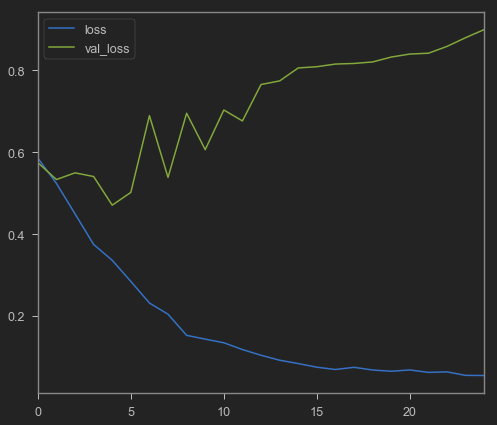

In [573]:
# Visualize loss and val_loss

pd.DataFrame(metrics).plot(y=["loss","val_loss"])

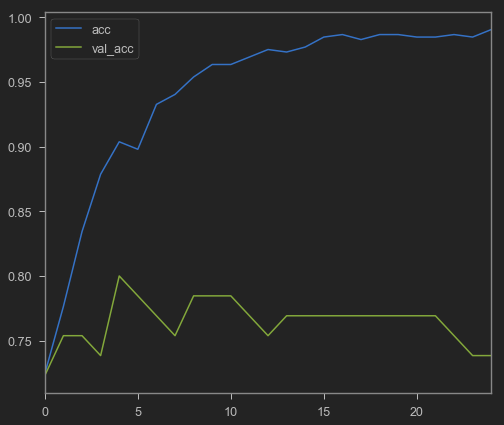

In [574]:
# Visualize acc and val_acc

pd.DataFrame(metrics).plot(y=["acc","val_acc"])

In [575]:
# Load model

model = load_model("./model/LSTM_TH_no_stopwords.h5")

In [576]:
# Evaluate with test set

yhat = model.predict_classes(X_test)
yhat_prob = model.predict_proba(X_test)
report = classification_report(y_test, yhat)
con_mat = confusion_matrix(y_test, yhat, labels=[1,0])
yhat_dummy = to_categorical(yhat)

In [577]:
print(report)

              precision    recall  f1-score   support

           0       0.67      0.47      0.55        17
           1       0.83      0.92      0.87        48

   micro avg       0.80      0.80      0.80        65
   macro avg       0.75      0.69      0.71        65
weighted avg       0.79      0.80      0.79        65



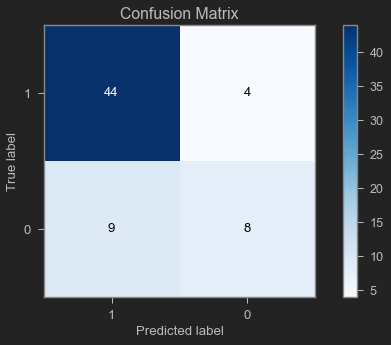

In [578]:
skplt.metrics.plot_confusion_matrix(y_test, yhat, labels=[1,0], figsize=(10,5))

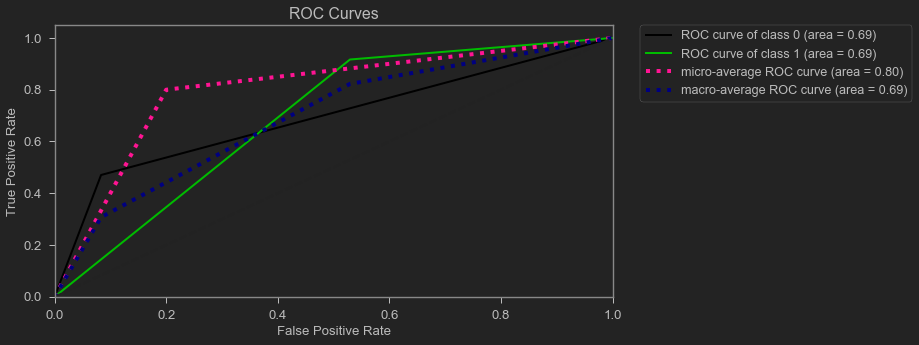

In [579]:
skplt.metrics.plot_roc(y_test, yhat_dummy, text_fontsize = 'medium', figsize = (10,5))
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0)
plt.show()

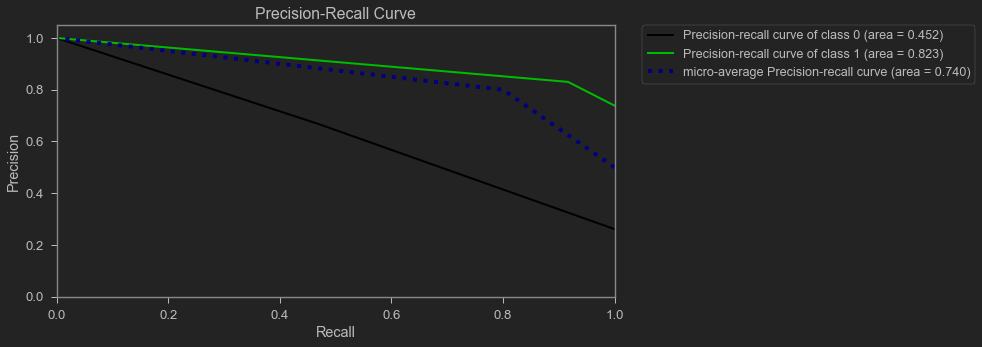

In [580]:
skplt.metrics.plot_precision_recall(y_test, yhat_dummy, text_fontsize = 'medium', figsize = (10,5))
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0)
plt.show()

### Analysis on Error

In [581]:
# Create dataframe to do analysis on error
df_X_test_copy = df_X_test.copy()

# Reset index
df_X_test_copy.reset_index(drop=True, inplace=True)

# Insert new column yhat
df_X_test_copy["yhat"] = pd.DataFrame(yhat, columns=['yhat'])

# Compare y ground truth with yhat
df_X_test_copy['test'] = df_X_test_copy["score"] != df_X_test_copy["yhat"]

# Show comments
df_X_test_copy.loc[df_X_test_copy["test"] == True, ["comment_th", 'score', 'yhat', 'hospital']]

,comment_th,score,yhat,hospital
1,"ถามอะไรหน่อยได้ไหม พอจะรู้จักใครที่เขามีปัญหาสุขภาพ เช่น คนที่อยากจะลดน้ำหนัก กระชับสัดส่วน ต้นแขนต้นขา หน้าท้อง เพิ่มน้ำหนัก อยากผิวขาว มีออร่า สิว เพิ่มหน้าอก อยากเพิ่มนาด ใหญ่ ยาว อึด ทน นาน เพิ่มน้ำ เพิ่มรอบให้ยาวนาน และคนที่มีปัญหาเรื่องการขับถ่าย อย่าง2-3วันถ่ายที่และญาติผู้ใหญ่เป็นโรค ประจำ เช่น.ความดัน,เบาหวาน,โรคหัวใจ,โรคมะเร็ง ถ้ามีช่วยแนะนำให้ด้วยนะ ขอบคุณมากๆๆจร้า",1,0,rama
6,การรักษาถือว่าโอเครนะคร๊ แต่เรื่องที่จอดรถควรปรับปรุงเป้นอย่างมาก เพราะผู้ป่วยมาหาหมอแต่ละทีไม่มีที่จอดรถเลย ในโรงบาลก้อบอกให้จอดได้แต่เจ้าหน้า ตายห่าพอดีแระ คนป่วยรึญาติมาเยี่ยมผู้ป่วยต้องไปรถไว้ปั้มน้ำมันแล้วนั่งแท็กซี่มา แล้วจะมารถส่วนตัวไว้เพื่อ โรงบาลก้อใหญ่ แระ รวย แนะนำนะคร๊ทำที่รถเหมือนในห้างเลยคร๊ ทำหลายๆชั้นเพื่อรองรับคุนหมอ พยาบาลแระเจ้าหน้า ผู้ป่วยไม่ต้องสนใจหรอกคร๊,0,1,rama
14,คุณหมอเข้าของไข้ผ่าตัดดี แต่นศพ ดึงสายเลือดออก จึงต้องทำให้ผ่ารอบสอง ต้องโทรหาอาจารย์ตลอดการผ่า รอดตายมาได้ จนทำให้คอเป็นถึงทุกวันนี้ คอยึด คอตึง กลืนยาเม็ดใหญ่ไม่ได้ พยาบาลแผนกคอนิสัยน่ารักแต่แผนงรังสี หมอดีค่ะ ให้คำปรึกษาดี ทุกอย่างโอเคหมด แย่ตรงผ่าคอรอบสองครั้งนั้นค่ะ จนเป็นปีแล้ว คอก็ไม่ดีขึ้นค่ะ,0,1,siriraj
23,ด้วยขื่อเสียงที่มีมายาวนาน และมีคนใกล้ชิดเข้ารับการรักษา และดิฉันก็เป็นหนึ่งในผู้บริจาคให้มูลนิธิรามาธิบดีมาอย่างยาวนาน แต่พอคุณพ่อเข้ารับการรักษาในห้องอุบัติเหตุและฉุกเฉิน ไม่ได้รับการดูแลอย่างที่ควร ผนวกกับไม่มีห้อง เจ้าหน้าที่ โดยเฉพาะพยาบาลและเจ้ากน้าที่พูดจาไม่ดีเลย สุดท้ายต้องย้ายโรงพยาบาลค่ะ,0,1,rama
37,ห้องพักญาติผู้ป่วยหน้าห้องฉุกเฉินแอร์เสียเมื่อไรจะซ่อมซักที,1,0,chula
41,นั่งคอยครึ่งวัน แต่เข้าตรวจไม่ถึง5นาที เฮ้อ....ระบบเขาดีจิง,0,1,chula
48,ขอบคุณที่ดูแลร่างกายฉันตลอด31ปีก็มาที่นี่ดูแลกันที่นี่คลอดก็ที่นี่คนทุกคนต้องมีการซ่อมแซม ขอให้พระราชินีทั้งสามพระองค์ทรงพระเจริญ ผู้ก่อตั้งโรงบยาบาล,0,1,chula
50,การบริการของหมอและพยาบาลดีมาก. แต่ควรปรับปรุงคือเรื่องเวลา. รอตรวจนานมาก. รอรับยานานมากเช่นกันค่ะ,1,0,rama
55,ดีมากๆเพราะเคยพาลูกไป,0,1,chula
57,โรงบาลศิริราช ถือว่าดีอำดับต้นๆของประเทศเลบ หมอบริการดี พูดจาดี รักโรงบาลนี้สุด เพราะเคยไปใช้บริการมาหลายครั้ง พยาบาลพูดจาเป็นกันเอง เข้าใจผู้ป่วย ไม่รอนาน ไม่มีโรงบาลไหนดีเท่านี้แล้วละครับ ผมเคยไปนอนที่โรงบาลนี้ เหมือนปลายปีก่อน ตอนนั้นไปติดหวัดจสกการไปเที่ยวต่างประเทศ กลับมาเป็นไข้หวักหนัก เลยแอดมิทที่ฌรงพยายาบนี้ ค่าใช้จ่ายไม่แพง ดีกว่าเอกชนไปอีก,1,0,siriraj


In [583]:
# get tokenized sentence

df_X_test_copy["token_sent"] = df_X_test_copy["comment_th"].apply(lambda x: sent_tokenize(x, engine='deepcut'))

In [586]:
df_X_test_copy["token_sent"].head()

0    [หมอและพยาบาล, มีจิตใจที่เสียสละ..ให้การรักษาคนไข้อย่างสุดความสามารถ, และการจัดระบบที่นี่ดีมากค่ะ]                                                                                                                                                                                                                                                                                                                          
1    [ถามอะไรหน่อยได้ไหม, พอจะรู้จักใครที่เขามีปัญหาสุขภาพ, เช่น, คนที่อยากจะลดน้ำหนัก, กระชับสัดส่วน, ต้นแขนต้นขา, หน้าท้อง, เพิ่มน้ำหนัก, อยากผิวขาว, มีออร่า, สิว, เพิ่มหน้าอก, อยากเพิ่มนาด, ใหญ่, ยาว, อึด, ทน, นาน, เพิ่มน้ำ, เพิ่มรอบให้ยาวนาน, และคนที่มีปัญหาเรื่องการขับถ่าย, อย่าง2-3วันถ่ายที่และญาติผู้ใหญ่เป็นโรค, ประจำ, เช่น.ความดัน,เบาหวาน,โรคหัวใจ,โรคมะเร็ง, ถ้ามีช่วยแนะนำให้ด้วยนะ, ขอบคุณมากๆๆจร้า]       
2    [ดีมากคะ]                                                                                                                                                      

In [587]:
# perform POS on sentence

df_X_test_copy["token_sent_POS"] = df_X_test_copy["token_sent"].apply(lambda x : pos_tag_sents([x]))
df_X_test_copy["token_sent_POS"].tail()

60    [[(สถานที่คับแคบเมื่อเทียบกับจำนวนคนที่ใช้บริการ, NCMN), (แต่บุคคลากรเต็มที่กับการบริการมาก, DDAN), (ถึงแม้คนจะเยอะทุกวัน, ADVN), (ทุกเวลา, DONM), (แต่คุณหมอ, VACT), (พยาบาล, NCMN), (เจ้าหน้าที่ก็พูดจากับคนไข้ดีค่ะ, NCMN), (ถึงแม้บางคนจะหงุดหงิดบ้างแต่โดยรวมแล้วน่ารักทุกคนค่ะ, NCMN)]]                                                                                                                                                                                                                                                                                                                                                                                                    
61    [[(จะกี่ครั้ง, JCRG), (จะกี่หน, NCMN), (ต้องใช้ความอดทน, NCMN), (และ, JCRG), (ทำใจ, NCMN), (ทุกครั้งที่มา, NCMN), (ไม่ว่าตะพยายามคิดในแง่ดีแค่ไหนก็ไม่สามารถ, NCMN), (ทำให้ความรู้สึกดีขึ้นเลย, VACT), (ได้แต่คิดผิดที่กู, NCMN), (เสือกมาที่นี่เอง, PDMN), (ก็รู้ว่าไม่ได้มีเพียงแต่เรา, NCMN), (ทุกคนก็ใช้ความอดทนแต่ตลอ

In [588]:
# get only noun sentence
search_pos = 'NCMN'

sent_pos = []
for i in range(len(df_X_test_copy["token_sent_POS"])):
    sent = []
    for j in range(len(df_X_test_copy["token_sent_POS"][i])):
        group = []
        for k in range(len(df_X_test_copy["token_sent_POS"][i][j])):
            if search_pos in df_X_test_copy["token_sent_POS"][i][j][k]:
                group.append(df_X_test_copy["token_sent_POS"][i][j][k])
        sent.append(group)
    sent_pos.append(sent)

In [589]:
# insert into dataframe

df_X_test_copy["token_sent_POS_NCMN"] = pd.DataFrame(sent_pos)

In [591]:
df_X_test_copy[df_X_test_copy['yhat']==0].head()

,comment_th,score,hospital,token_remove_stopwords,comment_remove_stopwords,token_no_stopwords,length_no_stopwords,yhat,test,token_sent,token_sent_POS,token_sent_POS_NCMN
1,"ถามอะไรหน่อยได้ไหม พอจะรู้จักใครที่เขามีปัญหาสุขภาพ เช่น คนที่อยากจะลดน้ำหนัก กระชับสัดส่วน ต้นแขนต้นขา หน้าท้อง เพิ่มน้ำหนัก อยากผิวขาว มีออร่า สิว เพิ่มหน้าอก อยากเพิ่มนาด ใหญ่ ยาว อึด ทน นาน เพิ่มน้ำ เพิ่มรอบให้ยาวนาน และคนที่มีปัญหาเรื่องการขับถ่าย อย่าง2-3วันถ่ายที่และญาติผู้ใหญ่เป็นโรค ประจำ เช่น.ความดัน,เบาหวาน,โรคหัวใจ,โรคมะเร็ง ถ้ามีช่วยแนะนำให้ด้วยนะ ขอบคุณมากๆๆจร้า",1,rama,"[ถาม, ไหม, , รู้จัก, มีปัญหา, สุขภาพ, , , คน, ลดน้ำหนัก, , กระชับ, สัดส่วน, , ต้นแขน, ต้นขา, , หน้าท้อง, , น้ำหนัก, , ผิวขาว, , ออ, ร่า, , สิว, , หน้าอก, , นาด, , , , อึด, , ทน, , , น้ำ, , รอบ, , คน, มีปัญหา, เรื่อง, ขับถ่าย, , 2, -, 3, ถ่าย, ญาติผู้ใหญ่, เป็นโรค, , ประจำ, , ., ความดัน, ,, เบาหวาน, ,, โรคหัวใจ, ,, โรคมะเร็ง, , แนะนำ, , ขอบคุณ, ๆๆจ, ร้า]","ถามไหม รู้จักมีปัญหาสุขภาพ คนลดน้ำหนัก กระชับสัดส่วน ต้นแขนต้นขา หน้าท้อง น้ำหนัก ผิวขาว ออร่า สิว หน้าอก นาด อึด ทน น้ำ รอบ คนมีปัญหาเรื่องขับถ่าย 2-3ถ่ายญาติผู้ใหญ่เป็นโรค ประจำ .ความดัน,เบาหวาน,โรคหัวใจ,โรคมะเร็ง แนะนำ ขอบคุณๆๆจร้า","[ถาม, ไหม, , รู้จัก, มีปัญหา, สุขภาพ, , คน, ลดน้ำหนัก, , กระชับ, สัดส่วน, , ต้นแขน, ต้นขา, , หน้าท้อง, , น้ำหนัก, , ผิวขาว, , ออ, ร่า, , สิว, , หน้าอก, , นาด, , อึด, , ทน, , น้ำ, , รอบ, , คน, มีปัญหา, เรื่อง, ขับถ่าย, , 2, -, 3, ถ่าย, ญาติผู้ใหญ่, เป็นโรค, , ประจำ, , ., ความดัน, ,, เบาหวาน, ,, โรคหัวใจ, ,, โรคมะเร็ง, , แนะนำ, , ขอบ, คุณๆ, ๆจ, ร้า]",68,0,True,"[ถามอะไรหน่อยได้ไหม, พอจะรู้จักใครที่เขามีปัญหาสุขภาพ, เช่น, คนที่อยากจะลดน้ำหนัก, กระชับสัดส่วน, ต้นแขนต้นขา, หน้าท้อง, เพิ่มน้ำหนัก, อยากผิวขาว, มีออร่า, สิว, เพิ่มหน้าอก, อยากเพิ่มนาด, ใหญ่, ยาว, อึด, ทน, นาน, เพิ่มน้ำ, เพิ่มรอบให้ยาวนาน, และคนที่มีปัญหาเรื่องการขับถ่าย, อย่าง2-3วันถ่ายที่และญาติผู้ใหญ่เป็นโรค, ประจำ, เช่น.ความดัน,เบาหวาน,โรคหัวใจ,โรคมะเร็ง, ถ้ามีช่วยแนะนำให้ด้วยนะ, ขอบคุณมากๆๆจร้า]","[[(ถามอะไรหน่อยได้ไหม, NCMN), (พอจะรู้จักใครที่เขามีปัญหาสุขภาพ, NCMN), (เช่น, RPRE), (คนที่อยากจะลดน้ำหนัก, NCMN), (กระชับสัดส่วน, NCMN), (ต้นแขนต้นขา, NCMN), (หน้าท้อง, NCMN), (เพิ่มน้ำหนัก, VACT), (อยากผิวขาว, NCMN), (มีออร่า, NCMN), (สิว, NCMN), (เพิ่มหน้าอก, NCMN), (อยากเพิ่มนาด, NCMN), (ใหญ่, VATT), (ยาว, VATT), (อึด, PNTR), (ทน, VACT), (นาน, ADVN), (เพิ่มน้ำ, NCMN), (เพิ่มรอบให้ยาวนาน, NCMN), (และคนที่มีปัญหาเรื่องการขับถ่าย, NCMN), (อย่าง2-3วันถ่ายที่และญาติผู้ใหญ่เป็นโรค, NCMN), (ประจำ, VATT), (เช่น.ความดัน,เบาหวาน,โรคหัวใจ,โรคมะเร็ง, NCMN), (ถ้ามีช่วยแนะนำให้ด้วยนะ, ADVN), (ขอบคุณมากๆๆจร้า, NCMN)]]","[(ถามอะไรหน่อยได้ไหม, NCMN), (พอจะรู้จักใครที่เขามีปัญหาสุขภาพ, NCMN), (คนที่อยากจะลดน้ำหนัก, NCMN), (กระชับสัดส่วน, NCMN), (ต้นแขนต้นขา, NCMN), (หน้าท้อง, NCMN), (อยากผิวขาว, NCMN), (มีออร่า, NCMN), (สิว, NCMN), (เพิ่มหน้าอก, NCMN), (อยากเพิ่มนาด, NCMN), (เพิ่มน้ำ, NCMN), (เพิ่มรอบให้ยาวนาน, NCMN), (และคนที่มีปัญหาเรื่องการขับถ่าย, NCMN), (อย่าง2-3วันถ่ายที่และญาติผู้ใหญ่เป็นโรค, NCMN), (เช่น.ความดัน,เบาหวาน,โรคหัวใจ,โรคมะเร็ง, NCMN), (ขอบคุณมากๆๆจร้า, NCMN)]"
4,แผนก #หนวยสิทธิประโยชน์ผู้รับบริการ ชั้น1 ตรงประตูทางเข้า แยกตึกชัย ควรที่จะปรับปรุง เรื้องบัตรคิว นะครับ อย่าก จะแนะนำ ให้ นำบัตรคิว มาวางก่อน ได้มัย ผู้รับบริการจะได้ ไม่ต้องไปต่อแถวรอครับ บางคน ก็แทรกแถว บางคนก็แซงคิว อย่ากให้เห็นใจคนที่เจารอ อะคับ บางทีบัตรคิว ก็เปลียนตำแหนงวาง บอกเลย แย่มาก . บอกเลยเป็นอย่างนีมาหลายปีละ ผมมาก่อน ตี4 ทึกครั้งเห็นทุกครั้ง ครับ แค่อย่ากแนะนำ,0,rama,"[แผนก, , #ห, นวย, สิทธิประโยชน์, ผู้รับ, บริการ, , ชั้น, 1, , ประตู, ทางเข้า, , แยก, ตึก, ชัย, , ที่จะ, ปรับปรุง, , เรื้อง, บัตร, คิว, , , อย่า, ก, , แนะนำ, , , บัตร, คิว, , วาง, , มัย, , ผู้รับ, บริการ, , ไม่ต้อง, แถว, รอ, , บางคน, , แทรก, แถว, , บางคน, แซงคิว, , อย่า, ก, เห็นใจ, คน, เจา, รอ, , อะ, คับ, , บัตร, คิว, , เปลียน, ตำ, แหนง, วาง, , , แย่มาก, , ., , นี, ปี, , ผม, , ตี, 4, , ทึก, , , อย่า, ก, แนะนำ]",แผนก #หนวยสิทธิประโยชน์ผู้รับบริการ ชั้น1 ประตูทางเข้า แยกตึกชัย ที่จะปรับปรุง เรื้องบัตรคิว อย่าก แนะนำ บัตรคิว วาง มัย ผู้รับบริการ ไม่ต้องแถวรอ บางคน แทรกแถว บางคนแซงคิว อย่ากเห็นใจคน

### Wordcloud

In [592]:
# store negative sentence that has NCMN POS
neg_list = []

# get index of all yhat that predicted 0
neg_index = df_X_test_copy[df_X_test_copy['yhat']==0].index

for i in neg_index:
    for j in range(len(df_X_test_copy['token_sent_POS_NCMN'][i])):
        neg_list.append(df_X_test_copy['token_sent_POS_NCMN'][i][j][0])

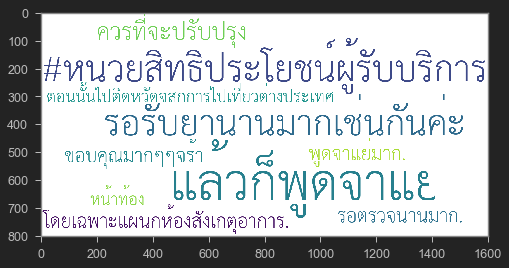

In [594]:
# Random sentence from predicted negative comment
items = random.sample(neg_list,10)
counter_neg_list = Counter(items)

w = WordCloud(font_path='.font\THSarabunNew.ttf',
              width=1600,height=800,mode='RGBA',
              background_color='white', max_words=20).fit_words(counter_neg_list)

plt.imshow(w)
plt.show()

### Conclusion

The model without removing stopwords seem to have better prediction of negative class the model with removed stopword. However, the experiment is not well signify because of very low number sample for negative class. Therefore, having more negative class could futhur improve in model prediction.